In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import imp
import sys
import pickle as plk
import importlib.util
from numpy.lib.scimath import sqrt as csqrt
from IPython.display import display, Math, clear_output
from scipy.signal import find_peaks

###############################################################
#LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/media/leonardo/datam02/Ring Resonator - Leonardo Pessôa/Ring-Resonator/Tutorial/')) #Current directory

###############################################################
#WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Léo/Documents/Facul/Capacitação/GitHub/90--optical-hybrid'))
spec_win.loader.exec_module(lumapi)

def fwhm(band, reflection, dB):
    from scipy.signal import find_peaks
    peak, pd = find_peaks(reflection)
    rmax = reflection[peak[np.argmax(reflection[peak])]]

    min = 0
    max = 0

    if dB == True: 
        dB = 3
        rmax = rmax-dB
    else: 
        dB = 0 
        rmax = rmax/2

    for i in range(peak[np.argmax(reflection[peak])], 0, -1):
        if (reflection[i] <(rmax) and reflection[i+1] < (rmax)):
            min = i
            break

    for i in range(peak[np.argmax(reflection[peak])], len(band) - 1):
        if (reflection[i-1] > (rmax) and reflection[i] < (rmax)):
            max = i
            break

    print('FWHM = '+ str(np.round((abs(band[max]-band[min]))*1e9,4)) + 'nm')

    r = (reflection[min] +reflection[max])/2

    
    return r,min,max

def imbalance(n,p):
    return 10*np.log10(p/n)

def CMRR(n,p):
    return 20*np.log(abs((p-n)/(p+n)))
    
Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
band = np.linspace(1500e-9, 1600e-9, 2000)
c0 = 299792458

C:\Users\Léo\AppData\Local\Temp\ipykernel_4816\97219970.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


# MMI 2x2

In [3]:
fdtd = lumapi.FDTD(filename="../CML/MMI_2X2.fsp")

In [10]:
# Creating the polygones used on the guide and defining some variables

W1 = 1.48e-6 # Article values
W2 = 1.48e-6
W3 = 1.6e-6
W4 = 0.5e-6
W5 = 0.7e-6
W6 = 0.2e-6
L1 = 1e-6
L2 = 2.4e-6
L3 = 1.6e-6
height = 0.22e-6

width = 0.5e-6 # Some helpful variables
xspan = 5e-6
yspan = 2e-6
core = 'Si (Silicon) - Palik'
substract = 'SiO2 (Glass) - Palik'

# Defining the structure of the polygones  

Poly1 = np.transpose([[0,  (W6/2 + (W5-W4)/2) + W4],
         [0,  (W6/2 + (W5-W4)/2)],
         [L1, (W6)/2],
         [L1, (W6/2+W5)]])

Poly2 = np.transpose([[0, -(W6/2 + (W5-W4)/2) - W4],
         [0, -(W6/2 + (W5-W4)/2)],
         [L1, -(W6)/2],
         [L1, -(W6/2+W5)]])

Poly3 = np.transpose([[L1, (W6/2+W5)],
         [L1+L2, (W1/2)],
         [L1+L2, -(W1/2)],
         [L1, -(W6/2+W5)]])

Poly4 = np.transpose([[L1+L2, (W1/2)],
         [L1+L2+L3, W2/2],
         [L1+L2+L3, -W2/2],
         [L1+L2, -(W1/2)]])

Poly5 = np.transpose([[L1+L2+L3, W2/2],
         [L1+L2+2*L3, (W1/2)],
         [L1+L2+2*L3, -(W1/2)],
         [L1+L2+L3, -W2/2]])

Poly6 = np.transpose([[L1+L2+2*L3, (W1/2)],
         [L1+2*L2+2*L3, W3/2],
         [L1+2*L2+2*L3, -W3/2],
         [L1+L2+2*L3, -(W1/2)]])

Poly7 = np.transpose([[2*L1+2*L2+2*L3, (W6/2 + (W5-W4)/2) + W4],
         [2*L1+2*L2+2*L3,  (W6/2 + (W5-W4)/2)],
         [L1+2*L2+2*L3, (W6)/2],
         [L1+2*L2+2*L3, (W6/2+W5)]])

Poly8 = np.transpose([[2*L1+2*L2+2*L3, -(W6/2 + (W5-W4)/2) - W4],
         [2*L1+2*L2+2*L3,  -(W6/2 + (W5-W4)/2)],
         [L1+2*L2+2*L3, -(W6)/2],
         [L1+2*L2+2*L3, -(W6/2+W5)]])


In [11]:
#Creating MMI structure based on the article

#fdtd.selectall()
#fdtd.delete()

fdtd.addpoly()
fdtd.addtogroup('MMI') # Adding all polygones on the same group
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0,
})
fdtd.set('vertices', Poly1) # Setting the vertices based on the created arrays
fdtd.set('name', 'Poly1')
fdtd.set('z span', height)
fdtd.set('material', core)

fdtd.addpoly()
fdtd.addtogroup('MMI')
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0
})
fdtd.set('vertices', Poly2)
fdtd.set('name', 'Poly2')
fdtd.set('z span', height)
fdtd.set('material', core)

fdtd.addpoly()
fdtd.addtogroup('MMI')
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0
})
fdtd.set('vertices', Poly3)
fdtd.set('name', 'Poly3')
fdtd.set('z span', height)
fdtd.set('material', core)

fdtd.addpoly()
fdtd.addtogroup('MMI')
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0
})
fdtd.set('vertices', Poly4)
fdtd.set('name', 'Poly4')
fdtd.set('z span', height)
fdtd.set('material', core)

fdtd.addpoly()
fdtd.addtogroup('MMI')
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0
})
fdtd.set('vertices', Poly5)
fdtd.set('name', 'Poly5')
fdtd.set('z span', height)
fdtd.set('material', core)

fdtd.addpoly()
fdtd.addtogroup('MMI')
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0
})
fdtd.set('vertices', Poly6)
fdtd.set('name', 'Poly6')
fdtd.set('z span', height)
fdtd.set('material', core)

fdtd.addpoly()
fdtd.addtogroup('MMI')
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0
})
fdtd.set('vertices', Poly7)
fdtd.set('name', 'Poly7')
fdtd.set('z span', height)
fdtd.set('material', core)

fdtd.addpoly()
fdtd.addtogroup('MMI')
fdtd.set({
    'x' : 0,
    'y' : 0,
    'z' : 0
})
fdtd.set('vertices', Poly8)
fdtd.set('name', 'Poly8')
fdtd.set('z span', height)
fdtd.set('material', core)


In [12]:
# Creating bends and rectangles used on the simulation

fdtd.unselectall()
fdtd.addobject('s_bend_wg') # Creating the bend
fdtd.addtogroup('Bends') # Adding the bends on the same group
fdtd.set({'name' :'bend1',
    'first axis' :'y',
    'rotation 1' :180,
    'x'          :0,
    'y'          :W6/2 + W5/2,
    'z'          :0,
    'base angle' :90,
    'base width' :width,
    'x span'     :xspan,
    'y span'     :yspan,
    'base height':height
})

fdtd.unselectall()
fdtd.addobject('s_bend_wg')
fdtd.addtogroup('Bends')
fdtd.set({
    'name'       :'bend2',
    'x'          : -(L1+L2+L3),
    'y'          :-2e-6 - W6/2 - W5/2,
    'z'          :0,
    'base angle' :90,
    'base width' :width,
    'x span'     :xspan,
    'y span'     :yspan,
    'base height':height
})

fdtd.unselectall()
fdtd.addobject('s_bend_wg')
fdtd.addtogroup('Bends')
fdtd.set({
    'name'       :'bend3',
    'x'          :2*L1+2*L2+2*L3,
    'y'          :W6/2 + W5/2,
    'z'          :0,
    'base angle' :90,
    'base width' :width,
    'x span'     :xspan,
    'y span'     :yspan,
    'base height':height
})

fdtd.unselectall()
fdtd.addobject('s_bend_wg')
fdtd.addtogroup('Bends')
fdtd.set({'name' :'bend4',
    'first axis' :'y',
    'rotation 1' :180,
    'x'          :2*L1+2*L2+2*L3+xspan,
    'y'          :-W6/2 - W5/2 - yspan,
    'z'          :0,
    'base angle' :90,
    'base width' :width,
    'x span'     :xspan,
    'y span'     :yspan,
    'base height':height
})

fdtd.unselectall()
fdtd.addrect() # Creating the rectangles
fdtd.addtogroup('Extensions') # Adding the rectangles on the same group
fdtd.set({
    'name'    :'extension1',
    'x'       :-xspan - width,
    'x span'  :1e-6,
    'y'       :W6/2 + W5/2 + yspan,
    'y span'  :width,
    'z'       :0,
    'z span'  :height,
    'material':core
})

fdtd.unselectall()
fdtd.addrect()
fdtd.addtogroup('Extensions')
fdtd.set({
    'name'    :'extension2',
    'x'       :-xspan - width,
    'x span'  :1e-6,
    'y'       :-W6/2 - W5/2 - yspan,
    'y span'  :width,
    'z'       :0,
    'z span'  :height,
    'material':core
})

fdtd.unselectall()
fdtd.addrect()
fdtd.addtogroup('Extensions')
fdtd.set({
    'name'    :'extension3',
    'x'       :2*(L1+L2+L3) + xspan + 0.5e-6,
    'x span'  :1e-6,
    'y'       :W6/2 + W5/2 + yspan,
    'y span'  :width,
    'z'       :0,
    'z span'  :height,
    'material':core
})

fdtd.unselectall()
fdtd.addrect()
fdtd.addtogroup('Extensions')
fdtd.set({
    'name'    :'extension4',
    'x'       :2*(L1+L2+L3) + xspan + 0.5e-6,
    'x span'  :1e-6,
    'y'       :-W6/2 - W5/2 - yspan,
    'y span'  :width,
    'z'       :0,
    'z span'  :height,
    'material':core
})

In [79]:
# Creating simulation region and ports

fdtd.unselectall()
fdtd.addfdtd()
fdtd.set({
    'x'            : (L1+L2+L3),
    'x span'       : 2*(L1+L2+L3+xspan) + 2e-6,
    'y'            : 0,
    'y span'       : 5*yspan,
    'z'            : 0,
    'z span'       : 5e-6,
    'mesh accuracy': 4, 
    'z min bc'     : 'PML', # Defining boundaries as PML
    'z max bc'     : 'PML',
    'y max bc'     : 'PML',
    'y min bc'     : 'PML',
    'background material' : substract # Using SiO2 on the substract
})

# Creating the ports
fdtd.unselectall()
fdtd.addport() 
fdtd.set({
    'x'      : -xspan - width,
    'y'      : W6/2 + W5/2 + yspan,
    'y span' : 4e-6,
    'z'      : 0,
    'z span' : 4e-6
})

fdtd.unselectall()
fdtd.addport()
fdtd.set({
    'x'      : -xspan - width,
    'y'      : -(W6/2 + W5/2 + yspan),
    'y span' : 4e-6,
    'z'      : 0,
    'z span' : 4e-6
})

fdtd.unselectall()
fdtd.addport()
fdtd.set({
    'x'        : 2*(L1+L2+L3) + xspan + 0.5e-6,
    'y'        : W6/2 + W5/2 + yspan,
    'y span'   : 4e-6,
    'z'        : 0,
    'z span'   : 4e-6,
    'direction': 'Backward'
})

fdtd.unselectall()
fdtd.addport()
fdtd.set({
    'x'      : 2*(L1+L2+L3) + xspan + 0.5e-6,
    'y'      : -(W6/2 + W5/2 + yspan),
    'y span' : 4e-6,
    'z'      : 0,
    'z span' : 4e-6,
    'direction': 'Backward'
})

# Setting monitor points
fdtd.select('FDTD::ports')
fdtd.set('monitor frequency points', 200)

fdtd.unselectall()
fdtd.addprofile() # Creating Field monitor
fdtd.set({
    'x'            : (L1+L2+L3),
    'x span'       : 2*(L1+L2+L3+xspan) + 2e-6,
    'y'            : 0,
    'y span'       : 5*yspan,
    'z'            : 0,
    'override global monitor settings':1,
    'frequency points': 200
})

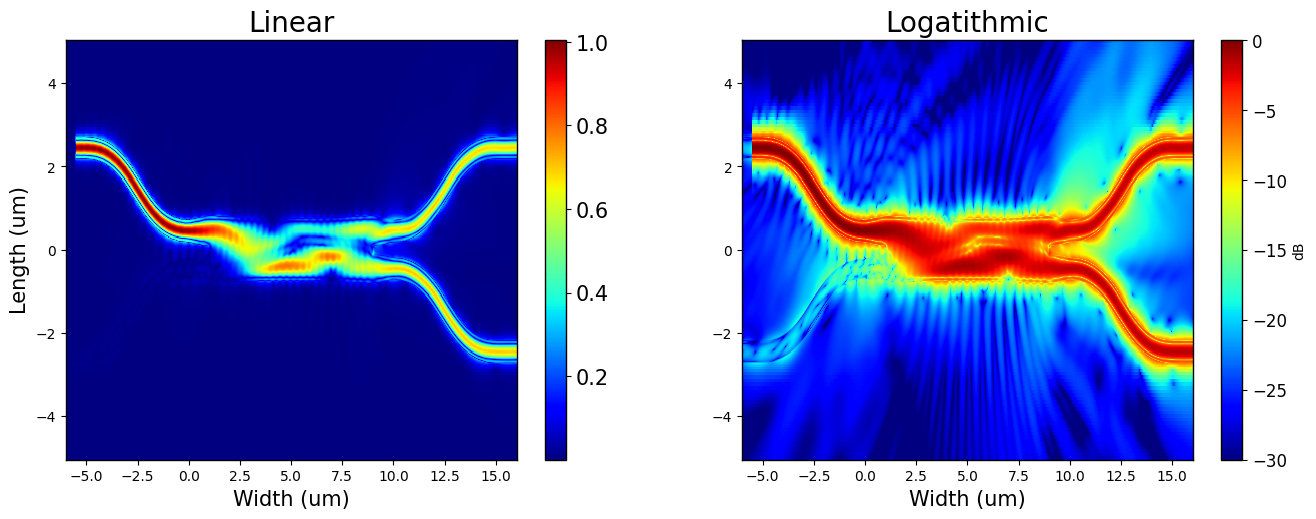

In [145]:
# Plot Linear Field Monitor Graph

figure1 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = fdtd.getresult('monitor','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Width (um)',fontsize=15)
plt.ylabel('Length (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30)
plt.xlabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_MMI')

In [5]:
 # Getting results
S1 = fdtd.getresult('FDTD::ports::port 1', 'T')
S2 = fdtd.getresult('FDTD::ports::port 2', 'T')
S3 = fdtd.getresult('FDTD::ports::port 3', 'T') 
S4 = fdtd.getresult('FDTD::ports::port 4', 'T')

T1 = (S1['T'])
T1log = 10*np.log10(T1)
T2 = (S2['T'])
T2log = 10*np.log10(T2)
T3 = (S3['T'])
T3log = 10*np.log10(T3)
T4 = (S4['T'])
T4log = 10*np.log10(T4)

C:\Users\Léo\AppData\Local\Temp\ipykernel_10788\3636683062.py:10: RuntimeWarning: invalid value encountered in log10
  T2log = 10*np.log10(T2)


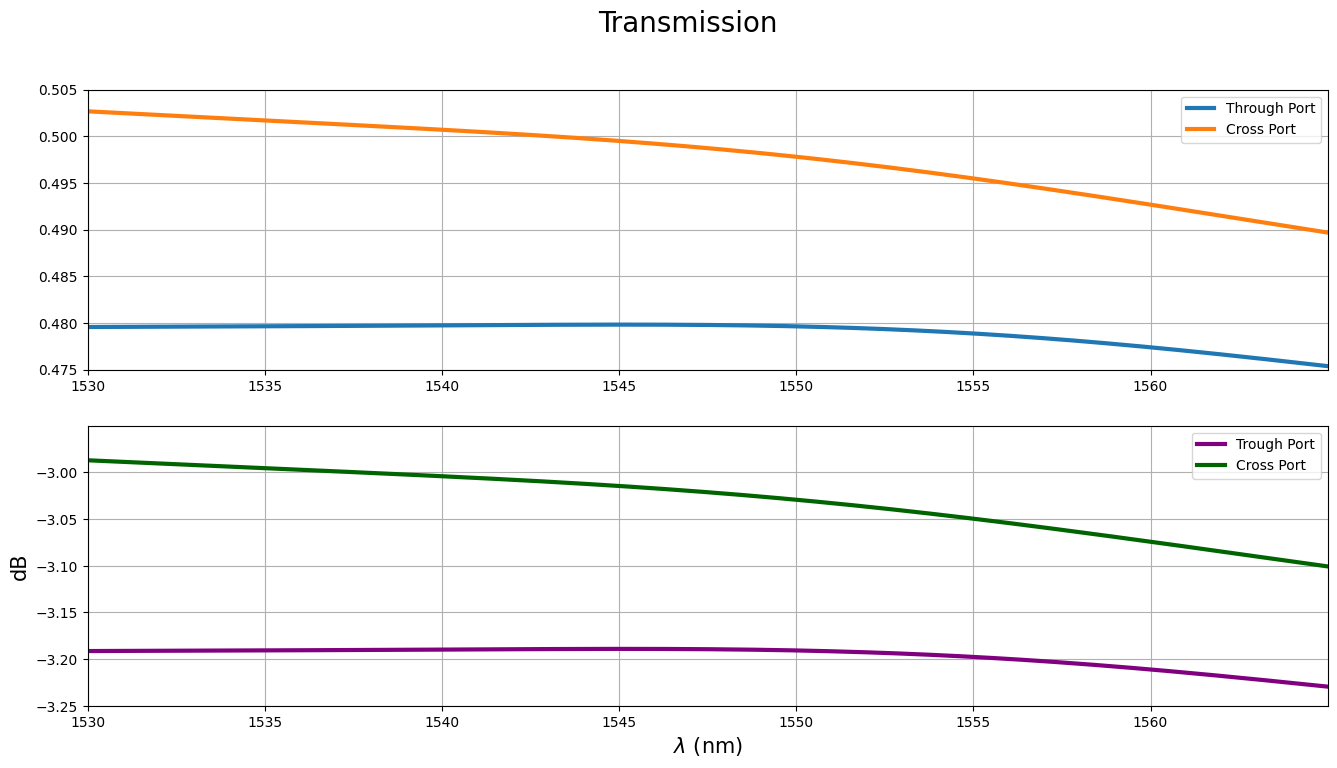

In [6]:
figure2, fig2 = plt.subplots(2,1,figsize=(16,8))

wavelength = S1['lambda']

figure2.suptitle('Transmission', size = 20)

fig2[0].plot(wavelength*1e9, T3, linewidth = 3, label = 'Through Port')
fig2[0].plot(wavelength*1e9, T4, linewidth = 3, label = 'Cross Port')
fig2[0].set_xticks(np.arange(1530,1565,5))
fig2[0].legend()
fig2[0].set_xlim(1530,1565)
fig2[0].grid()
fig2[0].set_yticks(np.arange(0.475, 0.505,0.005))
fig2[0].set_ylim(0.475,0.505)

fig2[1].plot(wavelength*1e9, T3log, linewidth = 3, label = 'Trough Port', color = 'purple')
fig2[1].plot(wavelength*1e9, T4log, linewidth = 3, label = 'Cross Port', color = 'darkgreen')
fig2[1].set_xticks(np.arange(1530,1565,5))
fig2[1].set_xlim(1530,1565)
fig2[1].legend()
fig2[1].grid()
fig2[1].set_yticks(np.arange(-3.25, -2.95,0.05))
fig2[1].set_ylim(-3.25,-2.95)
fig2[1].set_xlabel('$\lambda$ (nm)', size = 15)
fig2[1].set_ylabel('dB', size = 15)
plt.savefig('../Documentation/Figures/Transmission_MMI')

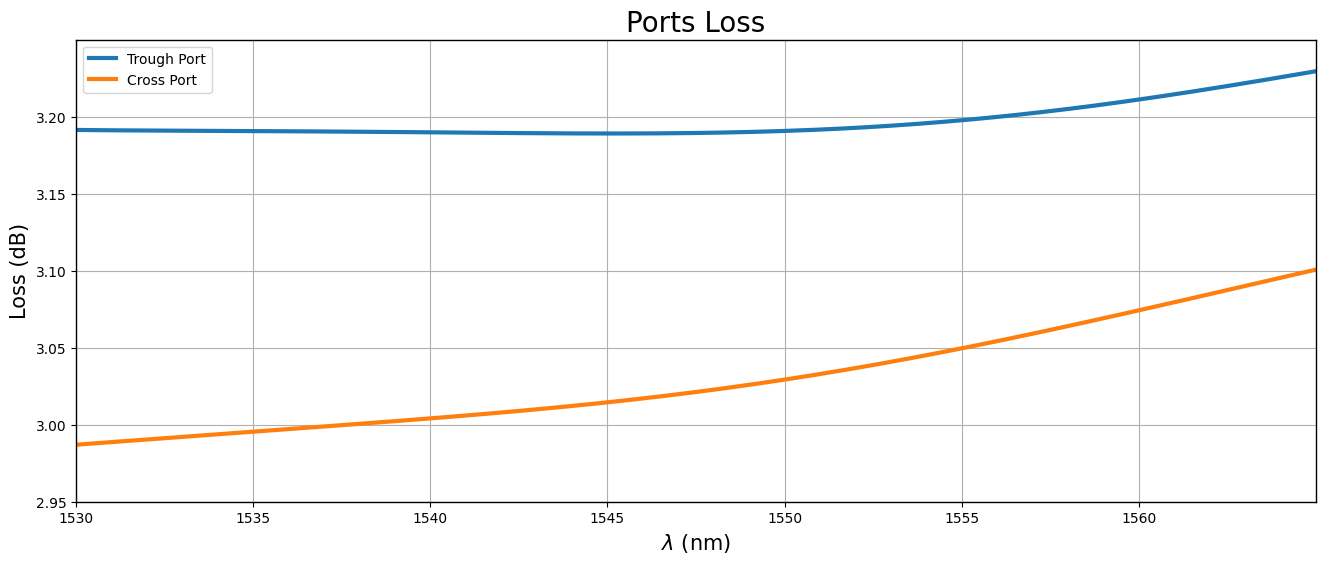

In [147]:
figure3 = plt.figure(figsize = (16,6))

plt.plot(wavelength*1e9, -T3log, linewidth = 3, label = 'Trough Port')
plt.plot(wavelength*1e9, -T4log, linewidth = 3, label = 'Cross Port')
plt.xticks(np.arange(1530,1565,5))
plt.title
plt.xlim(1530,1565)
plt.legend()
plt.grid()
plt.yticks(np.arange(2.95,3.25,0.05))
plt.ylim(2.95,3.25)
plt.title('Ports Loss', size = 20)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('Loss (dB)', size = 15)
plt.savefig('../Documentation/Figures/Loss_MMI')

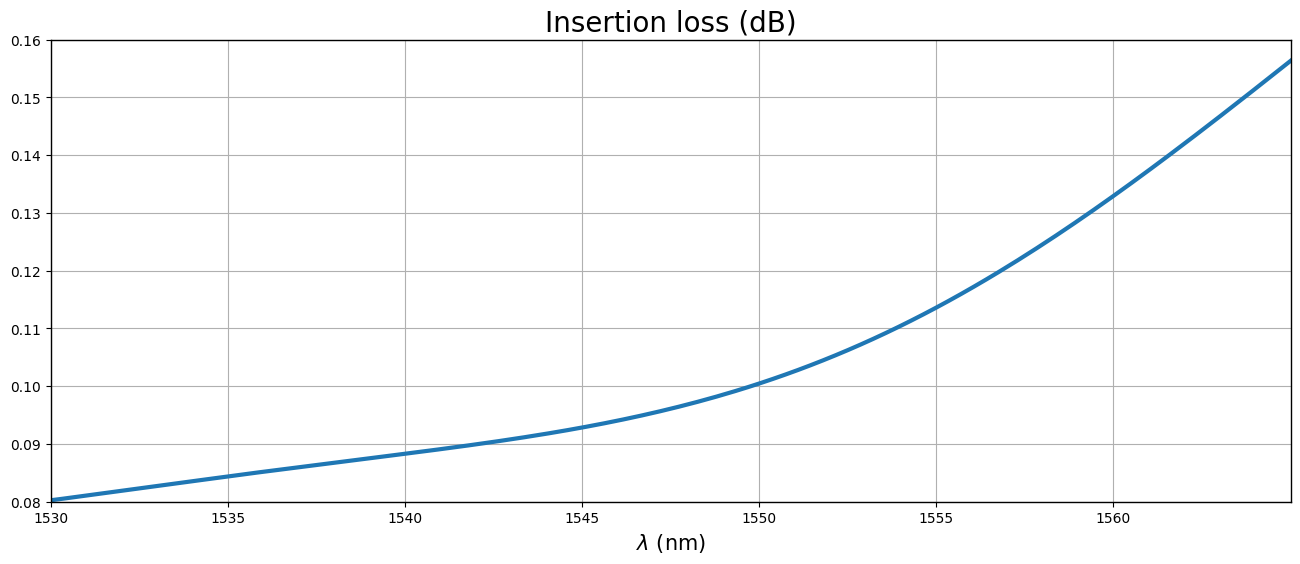

In [141]:
figure4 = plt.figure(figsize = (16,6))
loss =10*np.log10(T1)-(10*np.log10(T2 + T3 + T4))

plt.plot(wavelength*1e9, loss, linewidth = 3)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.ylim(0.08, 0.16)
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('Insertion loss (dB)', size = 20)
plt.savefig('../Documentation/Figures/InsertionLoss_MMI')

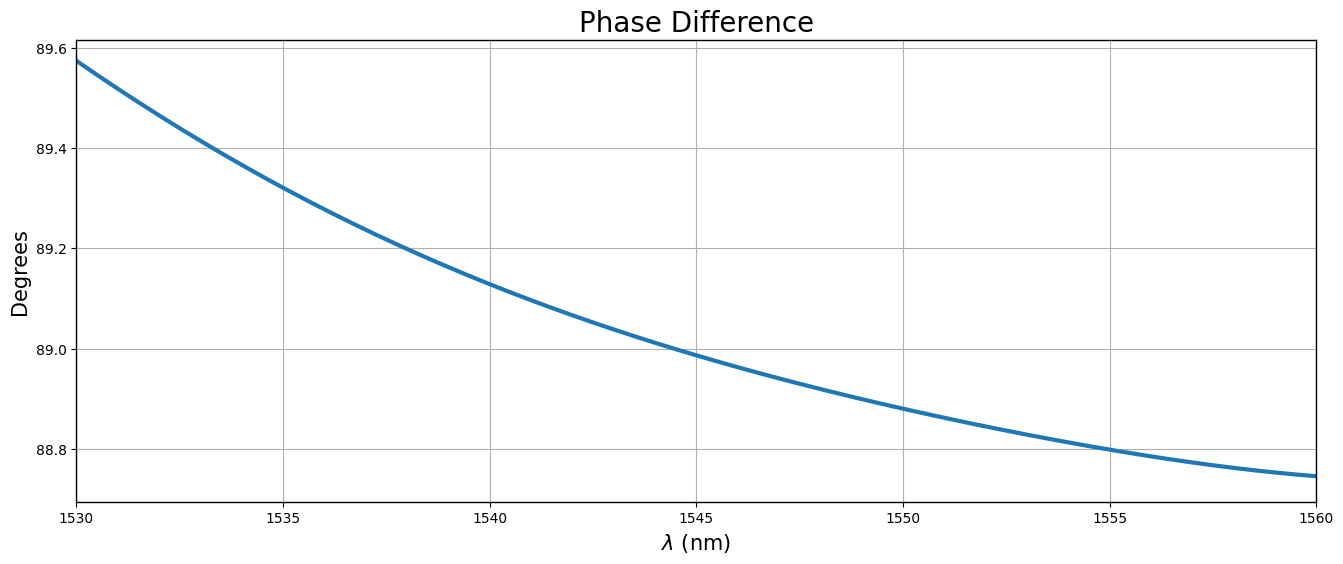

In [139]:
figure5 = plt.figure(figsize = (16,6))

S3 = fdtd.getresult('FDTD::ports::port 3','S')
S4 = fdtd.getresult('FDTD::ports::port 4', 'S')

Phase3 = fdtd.angle(S3['S'])
Phase4 = fdtd.angle(S4['S'])
Angle3 = fdtd.unwrap(Phase3)*180/(np.pi)
Angle4 = fdtd.unwrap(Phase4)*180/(np.pi)

plt.plot(wavelength*1e9, (Angle3 - Angle4), linewidth = 3)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('Degrees', size = 15)
plt.title('Phase Difference', size = 20)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1560)
plt.grid()
plt.savefig('../Documentation/Figures/PhaseDiference_MMI')

# Bend

In [3]:
fdtd = lumapi.FDTD('../CML/Bend.fsp')

In [13]:
radius = 4e-6
angle = 90
extension = 2e-6
port = 4e-6

In [14]:
fdtd.switchtolayout()
#fdtd.selectall()
#fdtd.delete()

fdtd.addobject('90_bend_wg')
fdtd.set({
    'x'          : 0,
    'y'          : 0,
    'z'          : 0,
    'base angle' : angle,
    'base height': height,
    'base width' : width,
    'radius'     : radius,
    'material'   : core,
    'name'       : 'Bend'
})

fdtd.unselectall()

fdtd.addrect()
fdtd.set({
    'x'        : -extension/2,
    'y'        : radius,
    'z'        : 0,
    'x span'   : extension,
    'y span'   : width,
    'z span'   : height,
    'material' : core,
    'name'     : 'Extension1'
})
fdtd.unselectall()

fdtd.addrect()
fdtd.set({
    'x'        : 2*extension,
    'y'        : -extension/2,
    'z'        : 0,
    'x span'   : width,
    'y span'   : extension,
    'z span'   : height,
    'material' : core,
    'name'     : 'Extension2'
})
fdtd.unselectall()

In [132]:
# Creating simulation region and ports

fdtd.unselectall()
fdtd.addfdtd()
fdtd.set({
    'x min'        : -extension,
    'x max'        : radius + extension,
    'y min'        : -extension,
    'y max'        : extension + radius,
    'z'            : 0,
    'z span'       : 5e-6,
    'mesh accuracy': 4, 
    'z min bc'     : 'PML', # Defining boundaries as PML
    'z max bc'     : 'PML',
    'y max bc'     : 'PML',
    'y min bc'     : 'PML',
    'background material' : substract # Using SiO2 on the substract
})

# Creating the ports
fdtd.unselectall()
fdtd.addport() 
fdtd.set({
    'x'      : -extension/2,
    'y'      : radius,
    'y span' : port,
    'z'      : 0,
    'z span' : port
})

fdtd.unselectall()
fdtd.addport()
fdtd.set({
    #'direction'      : 'Backward',
    'injection axis' :  'y-axis',
    'y'              : -extension/2,
    'x span'         :  port,
    'x'              : radius,
    'z'              : 0,
    'z span'         : port,
})

# Setting monitor points
fdtd.select('FDTD::ports')
fdtd.set('monitor frequency points', 200)

fdtd.unselectall()
fdtd.addprofile() # Creating Field monitor
fdtd.set({
    'x min'        : -extension,
    'x max'        : radius + extension,
    'y min'        : -extension,
    'y max'        : extension + radius,
    'z'            : 0,
    'override global monitor settings':1,
    'frequency points': 200
})

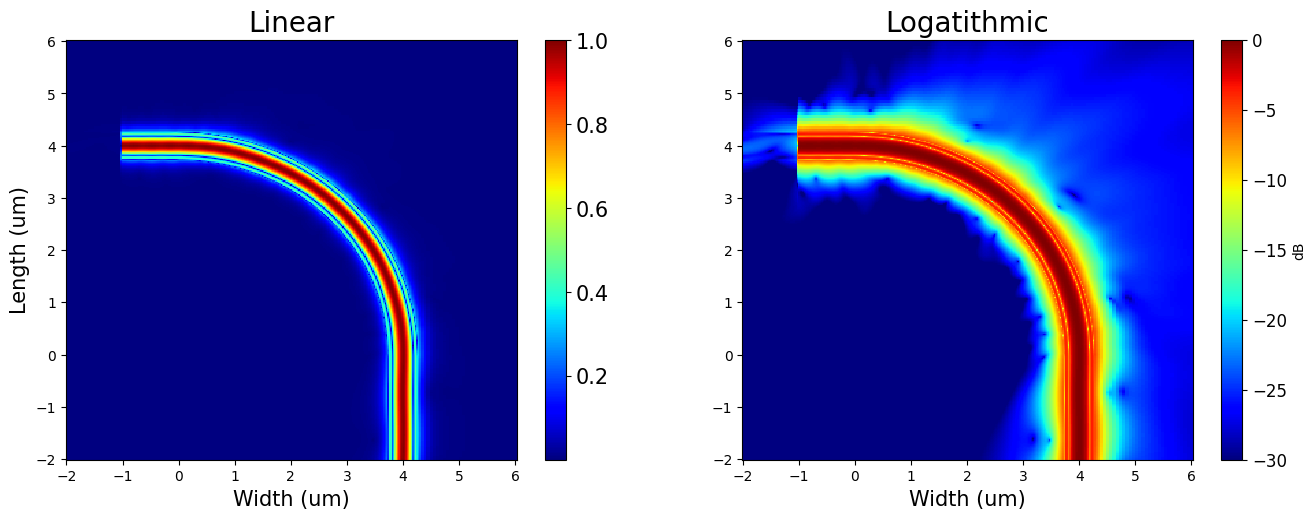

In [139]:
# Plot Linear Field Monitor Graph

figure6 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = fdtd.getresult('monitor','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Width (um)',fontsize=15)
plt.ylabel('Length (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30)
plt.xlabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Bend')

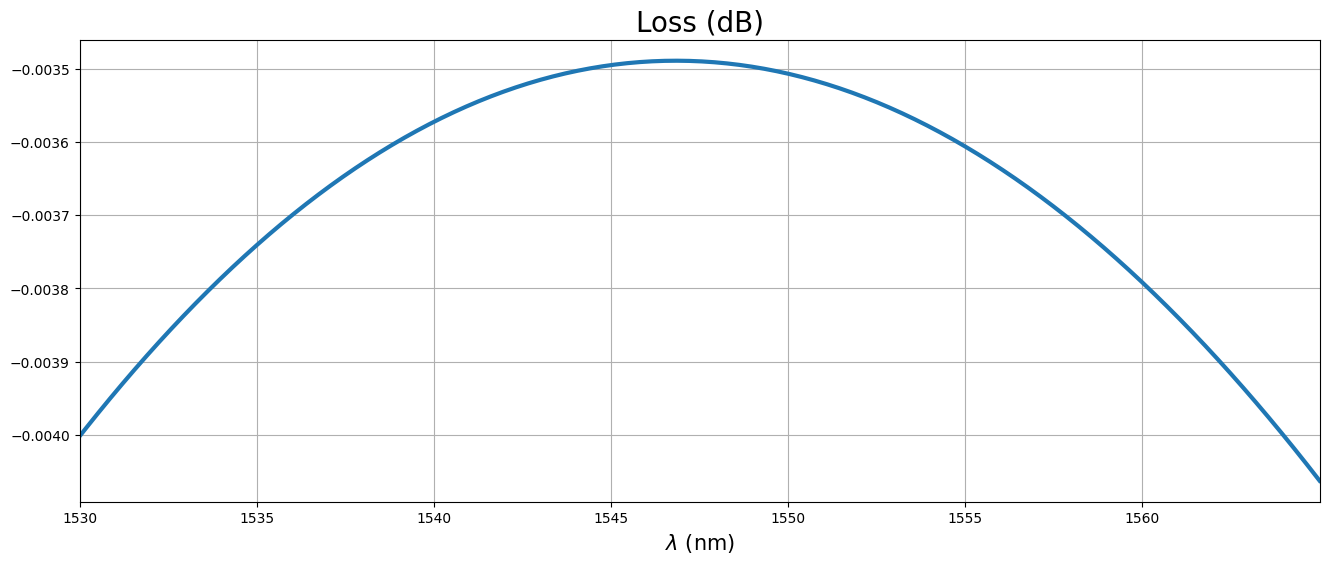

In [138]:
figure7 = plt.figure(figsize = (16,6))

R2 = fdtd.getresult('FDTD::ports::port 2', 'T')
T = 10*np.log10(abs(R2['T']))
wavelength = R2['lambda']

plt.plot(wavelength*1e9, T, linewidth = 3)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('Loss (dB)', size = 20)
plt.savefig('../Documentation/Figures/Loss_Bend')

# Y-Branch

In [19]:
fdtd = lumapi.FDTD(filename = '../CML/Y-branch.fsp')

In [16]:
W = [0.5e-6]
W = np.append(W,0.5e-6)
W = np.append(W,0.6e-6)
W = np.append(W,0.7e-6)
W = np.append(W,0.9e-6)
W = np.append(W,1.26e-6)
W = np.append(W,1.4e-6)
W = np.append(W,1.4e-6)
W = np.append(W,1.4e-6)
W = np.append(W,1.4e-6)
W = np.append(W,1.31e-6)
W = np.append(W,1.2e-6)
W = np.append(W,1.2e-6)
L = 2e-6
x = L/12

ext = 2e-6

In [18]:
fdtd.layoutmode()
#fdtd.selectall()
#fdtd.delete()

fdtd.addrect() # Generating input extensions
fdtd.set({
    'x min' : -ext,
    'x max' : 0,
    'y'     : 0,
    'y span': W[0],
    'z'     : 0,
    'z span': height,
    'material' : core,
    'name'     : 'Extension1'
})
fdtd.addtogroup('Extensions')
fdtd.unselectall()

for i in range(12): # Generating Y-Branch
    fdtd.addobject('linear_taper')
    fdtd.set({
        'x'         : (i+0.5)*x,
        'y'         : 0,
        'thickness' : height,
        'angle_side': 90,
        'width_l'   : W[i],
        'width_r'   : W[i+1],
        'z'         : 0,
        'len'       : x,
        'material'  : core,
        'name'      : 'Y-Branch' + str(i)
    })
    fdtd.addtogroup('Y-Branch')
    fdtd.unselectall()

# Y-Branch out extensions
fdtd.addrect()   
fdtd.set({
    'x min' : 12*x,
    'x max' : 12*x + ext/2,
    'y'     : 0.1e-6 + W[0]/2,
    'y span': W[0],
    'z'     : 0,
    'z span': height,
    'material' : core,
    'name'     : 'Extension2'
})
fdtd.addtogroup('Extensions')
fdtd.unselectall()

fdtd.addrect()
fdtd.set({
    'x min' : 12*x,
    'x max' : 12*x + ext/2,
    'y'     : -(0.1e-6 + W[0]/2),
    'y span': W[0],
    'z'     : 0,
    'z span': height,
    'material' : core,
    'name'     : 'Extension3'
})

fdtd.addtogroup('Extensions')
fdtd.unselectall()

# Bends and Extensions
fdtd.addobject('90_bend_wg') 
fdtd.set({
    'x'          : 12*x + ext/2,
    'y'          : -(0.1e-6 + W[0]/2) - radius,
    'z'          : 0,
    'base angle' : angle,
    'base height': height,
    'base width' : width,
    'radius'     : radius,
    'material'   : core,
    'name'       : 'Bend2'
})
fdtd.unselectall()

fdtd.addrect()
fdtd.set({
    'x'        : 12*x + ext/2 + radius,
    'y'        : extension/2 + radius +(0.1e-6 + W[0]/2),
    'z'        : 0,
    'x span'   : width,
    'y span'   : extension,
    'z span'   : height,
    'material' : core,
    'name'     : 'Extension4'
})
fdtd.addtogroup('Extensions')
fdtd.unselectall()

fdtd.addrect()
fdtd.set({
    'x'        : 12*x + ext/2 + radius,
    'y'        : -extension/2 - radius -(0.1e-6 + W[0]/2),
    'z'        : 0,
    'x span'   : width,
    'y span'   : extension,
    'z span'   : height,
    'material' : core,
    'name'     : 'Extension5'
})
fdtd.addtogroup('Extensions')
fdtd.unselectall()

fdtd.addobject('90_bend_wg')
fdtd.set({
    'x'          : 12*x + ext/2,
    'y'          : (0.1e-6 + W[0]/2) + radius,
    'z'          : 0,
    'start angle': 270,
    'base height': height,
    'base width' : width,
    'radius'     : radius,
    'material'   : core,
    'name'       : 'Bend1'
})
fdtd.unselectall()


In [80]:
# Creating simulation region and ports
fdtd.select('FDTD')
fdtd.delete()

fdtd.unselectall()
fdtd.addfdtd()
fdtd.set({
    'x min'        : -ext,
    'x max'        : 12*x + ext/2 + radius + ext,
    'y min'        : -ext - radius - (0.1e-6 + W[0]/2),
    'y max'        : ext + radius + 0.1e-6 + W[0]/2,
    'z'            : 0,
    'z span'       : 5e-6,
    'mesh accuracy': 4, 
    'z min bc'     : 'PML', # Defining boundaries as PML
    'z max bc'     : 'PML',
    'y max bc'     : 'PML',
    'y min bc'     : 'PML',
    'background material' : substract # Using SiO2 on the substract
})

# Creating the ports
fdtd.unselectall()
fdtd.addport() 
fdtd.set({
    'x'      : -ext + 0.2e-6,
    'y'      : 0,
    'y span' : port,
    'z'      : 0,
    'z span' : port
})

# Creating the ports
fdtd.unselectall()
fdtd.addport() 
fdtd.set({
    'direction'      : 'Backward',
    'injection axis' :  'y-axis',
    'x'      : 12*x + ext/2 + radius,
    'y'      : extension/2 + radius +(0.1e-6 + W[0]/2),
    'x span' : port,
    'z'      : 0,
    'z span' : port
})

fdtd.unselectall()
fdtd.addport()
fdtd.set({
    #'direction'      : 'Backward',
    'injection axis' :  'y-axis',
    'y'              : -extension/2 - radius -(0.1e-6 + W[0]/2),
    'x span'         :  port,
    'x'              : 12*x + ext/2 + radius,
    'z'              : 0,
    'z span'         : port,
})

# Setting monitor points
fdtd.select('FDTD::ports')
fdtd.set('monitor frequency points', 200)

fdtd.unselectall()
fdtd.addprofile() # Creating Field monitor
fdtd.set({
    'x min'        : -ext,
    'x max'        : 12*x + ext/2 + radius + ext,
    'y min'        : -ext - radius - (0.1e-6 + W[0]/2),
    'y max'        : ext + radius + 0.1e-6 + W[0]/2,
    'z'            : 0,
    'override global monitor settings':1,
    'frequency points': 200
})

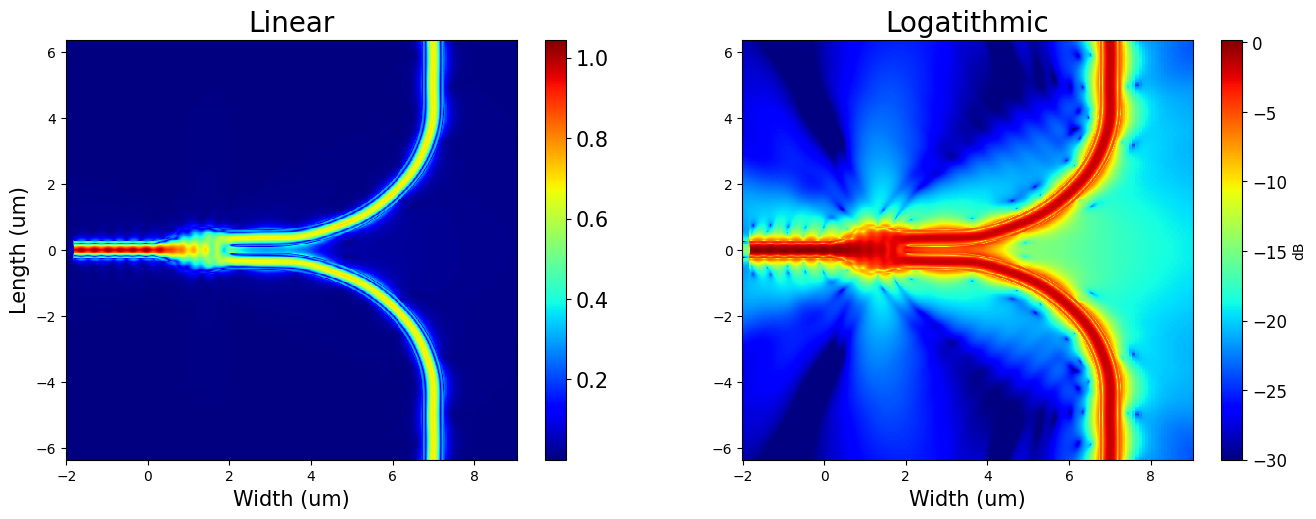

In [81]:
# Plot Linear Field Monitor Graph

figure8 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = fdtd.getresult('monitor','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Width (um)',fontsize=15)
plt.ylabel('Length (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30)
plt.xlabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Y-Branch')

In [90]:
 # Getting results
S1 = fdtd.getresult('FDTD::ports::port 1', 'T')
S2 = fdtd.getresult('FDTD::ports::port 2', 'T')
S3 = fdtd.getresult('FDTD::ports::port 3', 'T') 

T1 = abs(S1['T'])
T1log = 10*np.log10(T1)
T2 = abs(S2['T'])
T2log = 10*np.log10(T2)
T3 = abs(S3['T'])
T3log = 10*np.log10(T3)

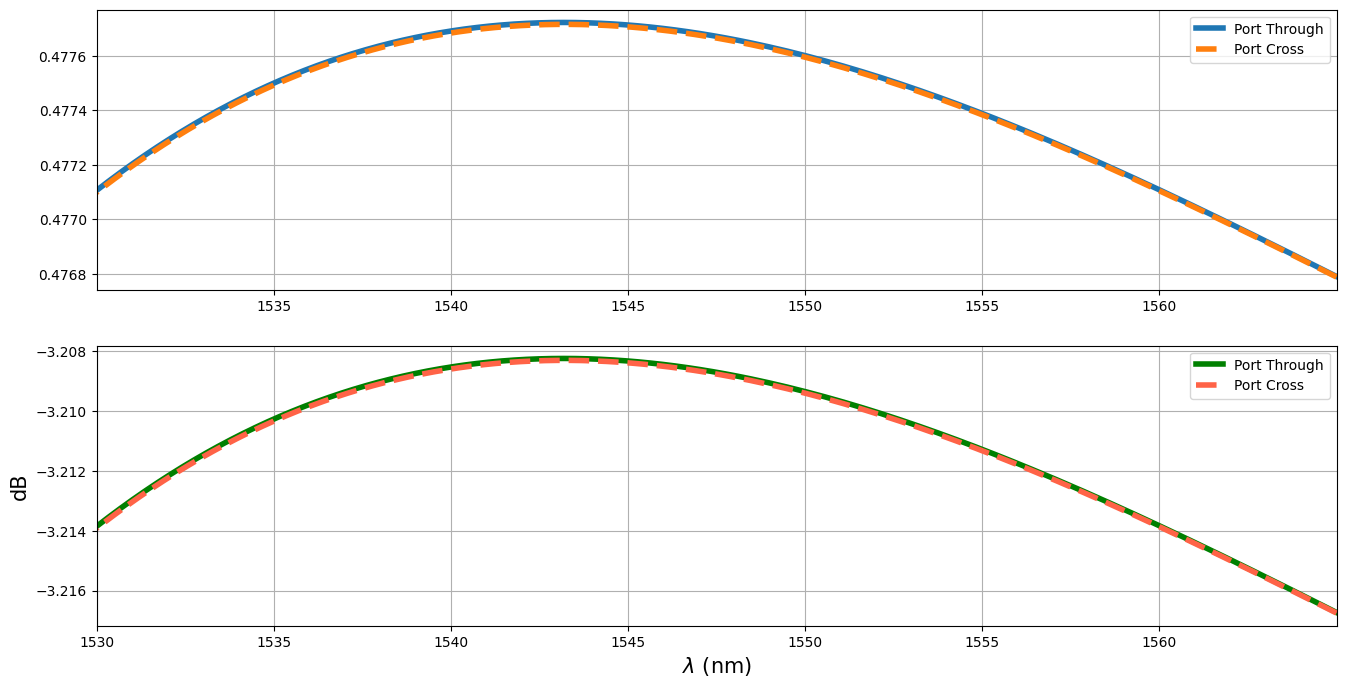

In [132]:
figure9, fig9 = plt.subplots(2,1,figsize=(16,8))

wavelength = S1['lambda']

figure9.suptitle('Transmission', size = 20)


fig9[0].plot(wavelength*1e9, T2,linewidth = 4, label = 'Port Through')
fig9[0].plot(wavelength*1e9, T3, '--', linewidth = 4, label = 'Port Cross')
fig9[0].set_xticks(np.arange(1535,1565,5))
fig9[0].legend()
fig9[0].set_xlim(1530,1565)
fig9[0].grid()

fig9[1].plot(wavelength*1e9, T2log, linewidth = 4, label = 'Port Through', color = 'green')
fig9[1].plot(wavelength*1e9, T3log,'--', linewidth = 4, label = 'Port Cross', color = 'tomato')
fig9[1].set_xticks(np.arange(1530,1565,5))
fig9[1].set_xlim(1530,1565)
fig9[1].legend()
fig9[1].grid()
fig9[1].set_xlabel('$\lambda$ (nm)', size = 15)
fig9[1].set_ylabel('dB', size = 15)
plt.savefig('../Documentation/Figures/Transmission_Y-Branch')

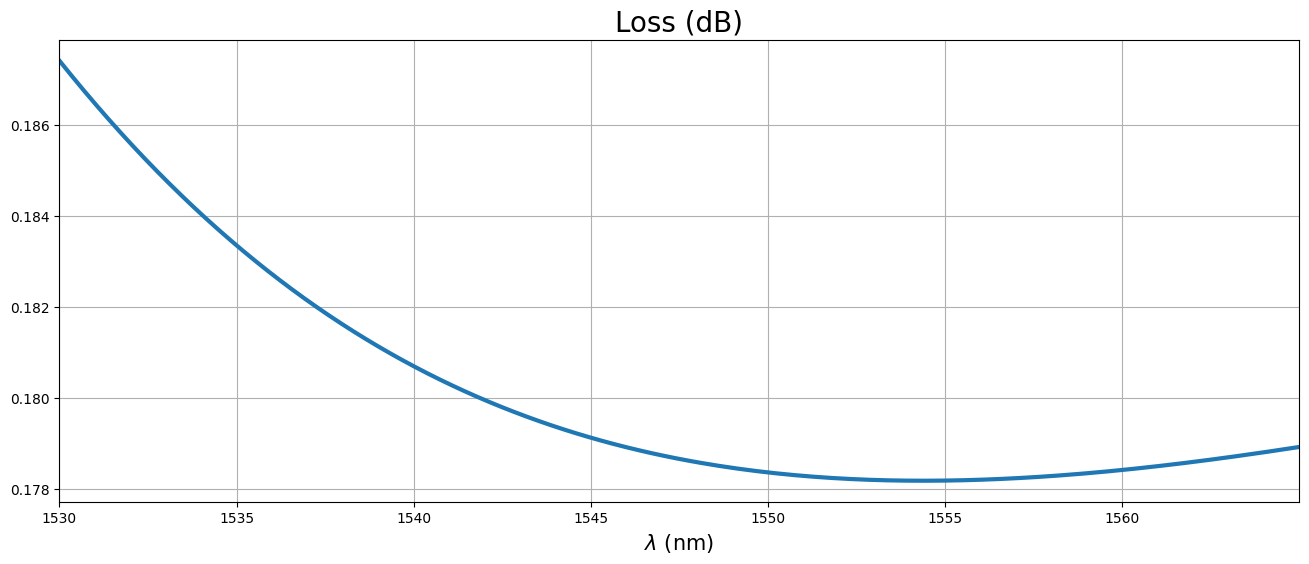

In [142]:
figure10 = plt.figure(figsize = (16,6))

Loss = T1log - 10*np.log10(T2+T3)

plt.plot(wavelength*1e9, Loss, linewidth = 3)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('Loss (dB)', size = 20)
plt.savefig('../Documentation/Figures/Loss_Y-Branch')

# Hybrid

FDTD


In [45]:
fdtd = lumapi.FDTD("../CML/Hybrid.fsp")

In [3]:

fdtd.save()
fdtd.close()

Lo Input Results

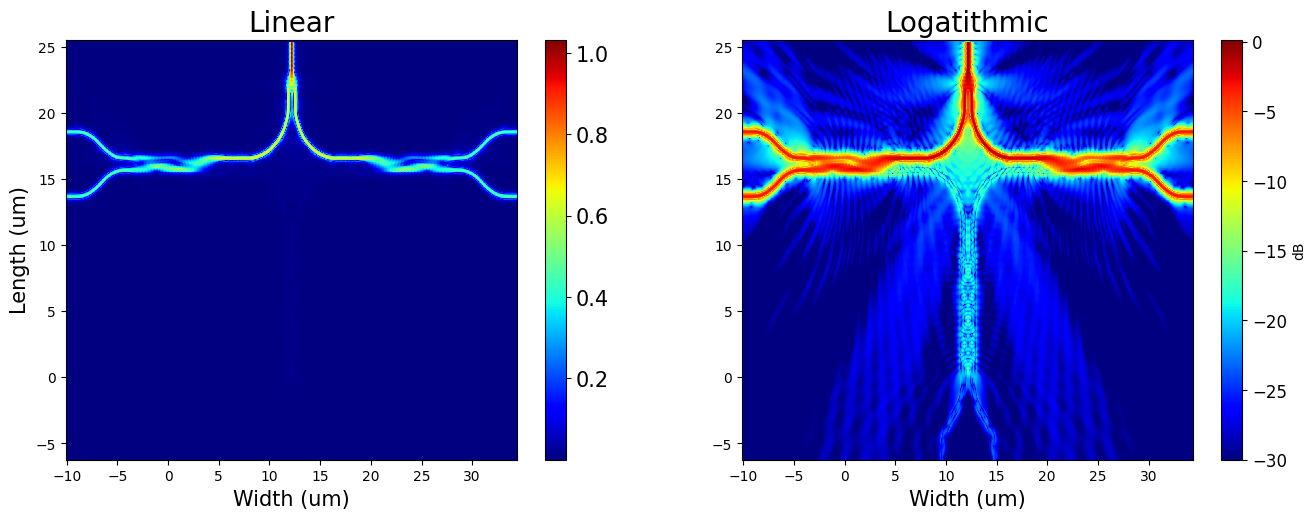

In [4]:
# Plot Linear Field Monitor Graph

figure11 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = fdtd.getresult('monitor','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Width (um)',fontsize=15)
plt.ylabel('Length (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30)
plt.xlabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Hybrid_Lo')

In [4]:
 # Getting results
S1 = fdtd.getresult('FDTD::ports::port 1', 'T')
S2 = fdtd.getresult('FDTD::ports::port 2', 'T')
S3 = fdtd.getresult('FDTD::ports::port 3', 'T')
S4 = fdtd.getresult('FDTD::ports::port 4', 'T')
S5 = fdtd.getresult('FDTD::ports::port 5', 'T')
S6 = fdtd.getresult('FDTD::ports::port 6', 'T') 
S7 = fdtd.getresult('FDTD::ports::port 7', 'T') 


T1 = abs(S1['T']) # Input Lo
T1log = 10*np.log10(T1) 
T2 = abs(S2['T']) # Ch-2, Qn
T2log = 10*np.log10(T2)
T3 = abs(S3['T']) # Ch-1, Qp
T3log = 10*np.log10(T3)
T4 = abs(S4['T']) # Ch-3, In
T4log = 10*np.log10(T4)
T5 = abs(S5['T']) # Ch-4, Ip
T5log = 10*np.log10(T5)
T6 = abs(S6['T'])
T6log = 10*np.log10(T6)
T7 = abs(S7['T'])
T7log = 10*np.log10(T7)

S1 = fdtd.getresult('FDTD::ports::port 1','S')
Phase1 = fdtd.angle(S1['S'])
P1 = fdtd.unwrap(Phase1)*180/(np.pi)

S2 = fdtd.getresult('FDTD::ports::port 2','S')
Phase2 = fdtd.angle(S2['S'])
P2 = fdtd.unwrap(Phase2)*180/(np.pi)

S3 = fdtd.getresult('FDTD::ports::port 3','S')
Phase3 = fdtd.angle(S3['S'])
P3 = fdtd.unwrap(Phase3)*180/(np.pi)

S4 = fdtd.getresult('FDTD::ports::port 4','S')
Phase4 = fdtd.angle(S4['S'])
P4 = fdtd.unwrap(Phase4)*180/(np.pi)

S5 = fdtd.getresult('FDTD::ports::port 5','S')
Phase5 = fdtd.angle(S5['S'])
P5 = fdtd.unwrap(Phase5)*180/(np.pi)

S6 = fdtd.getresult('FDTD::ports::port 6','S')
Phase6 = fdtd.angle(S6['S'])
P6 = fdtd.unwrap(Phase6)*180/(np.pi)

S7 = fdtd.getresult('FDTD::ports::port 7','S')
Phase7 = fdtd.angle(S7['S'])
P7 = fdtd.unwrap(Phase7)*180/(np.pi)

In [5]:
pointResults =     [[T1,T2, T3, T4, T5, T6, T7],
                    [T1log,T2log, T3log, T4log, T5log, T6log, T7log],
                    [P1, P2, P3, P4, P5, P6, P7]
                    ]

completeName = os.path.join('SavedData/','Hybrid_Lo_save.txt') # Saving the Transmission, Gain and Phase of the simulations
MSOutfile = open(completeName,'wb')
plk.dump(pointResults,MSOutfile)
MSOutfile.close

<function BufferedWriter.close>

In [3]:

file = open("SavedData/Hybrid_Lo_save.txt",'rb')
Lo = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Lo) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6
0,"[0.995989193013942, 0.996036909872597, 0.99607...","[0.23172392406673778, 0.2318574556736008, 0.23...","[0.22814650791005373, 0.22823728467804602, 0.2...","[0.2302322311997077, 0.23032851470317967, 0.23...","[0.22679694174664883, 0.22686334451860915, 0.2...","[6.048476691981593e-05, 6.008304065719644e-05,...","[6.564732710341403e-05, 6.498808859450636e-05,..."
1,"[-0.017453738653312702, -0.01724567743984202, ...","[-6.350291256671065, -6.347789342480439, -6.34...","[-6.417861743031138, -6.416134080893077, -6.41...","[-6.378338776987374, -6.376522929881977, -6.37...","[-6.443628060027184, -6.442356696475007, -6.44...","[-42.18353988581758, -42.212480968556434, -42....","[-41.82782951948755, -41.87166236152884, -41.8..."
2,"[[-171.62494478589224], [-172.205725151075], [...","[[70.23946567868688], [76.5821400840327], [82....","[[-19.23930105937428], [-12.890885713539399], ...","[[-166.63700495668738], [-160.31746921447603],...","[[103.79534265194465], [110.12069967842753], [...","[[-112.56629895625322], [-95.49145303707833], ...","[[-114.94993567934726], [-98.33687515193245], ..."


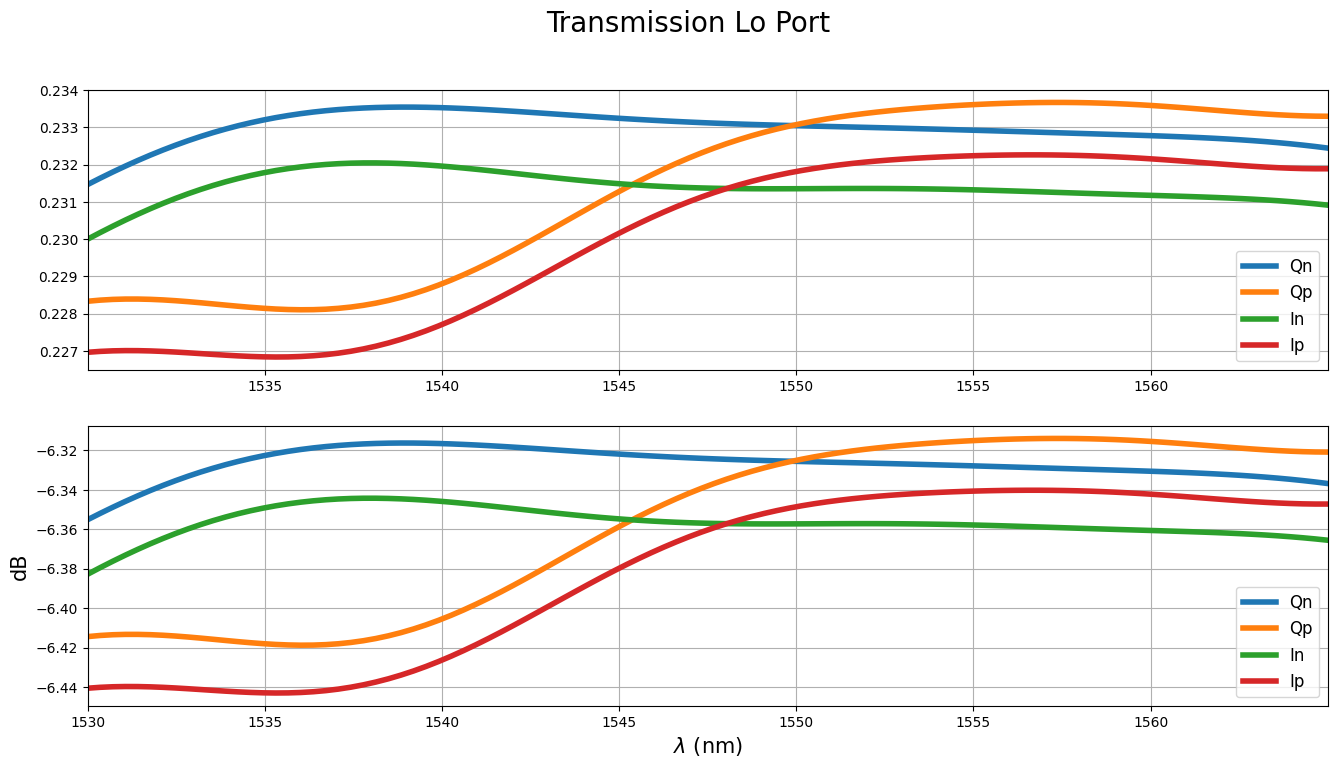

In [8]:
figure12, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,100)

figure12.suptitle('Transmission Lo Port', size = 20)


fig[0].plot(wavelength, Lo[0][1],linewidth = 4, label = 'Qn')
fig[0].plot(wavelength, Lo[0][2], linewidth = 4, label = 'Qp')
fig[0].plot(wavelength, Lo[0][3],linewidth = 4, label = 'In')
fig[0].plot(wavelength, Lo[0][4], linewidth = 4, label = 'Ip')
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].legend(fontsize = 12)
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength, Lo[1][1],linewidth = 4, label = 'Qn')
fig[1].plot(wavelength, Lo[1][2], linewidth = 4, label = 'Qp')
fig[1].plot(wavelength, Lo[1][3],linewidth = 4, label = 'In')
fig[1].plot(wavelength, Lo[1][4], linewidth = 4, label = 'Ip')
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_xlim(1530,1565)
fig[1].legend(fontsize = 12)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)
fig[1].set_ylabel('dB', size = 15)
plt.savefig('../Documentation/Figures/Transmission_Hybrid_Lo')

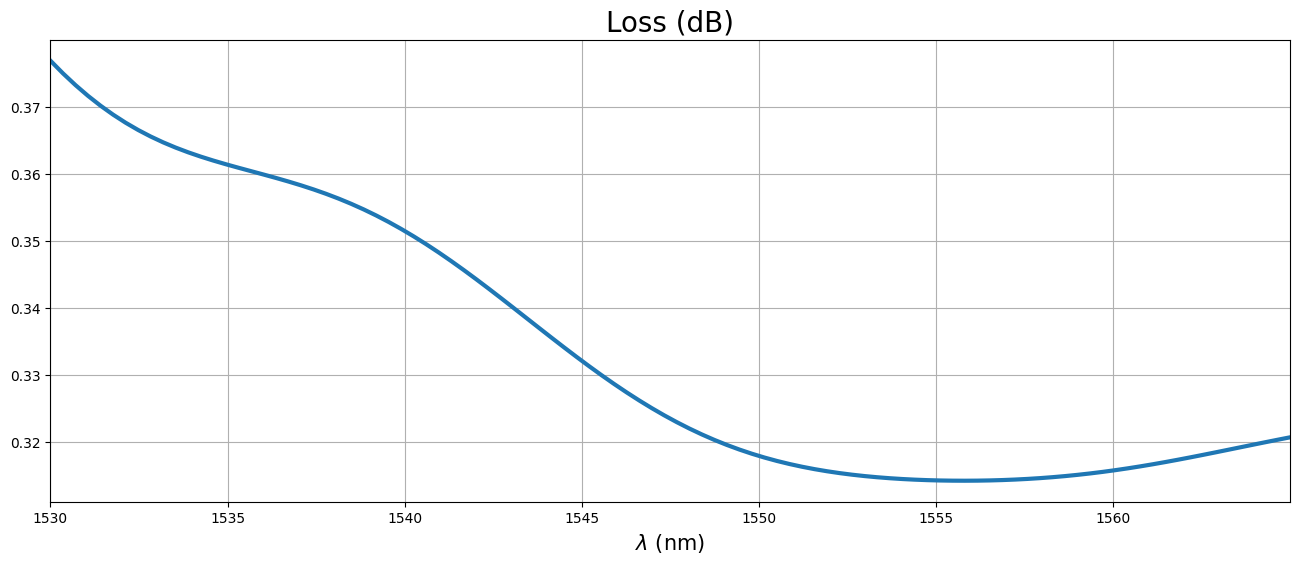

In [6]:
figure13 = plt.figure(figsize = (16,6))
wavelength = np.linspace(1530,1565,100)
Loss = -10*np.log10(Lo[0][1]+Lo[0][2]+Lo[0][3]+Lo[0][4]+Lo[0][5]+Lo[0][6])

plt.plot(wavelength, Loss, linewidth = 3)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('Loss (dB)', size = 20)
plt.savefig('../Documentation/Figures/Loss_Hybrid_Lo')

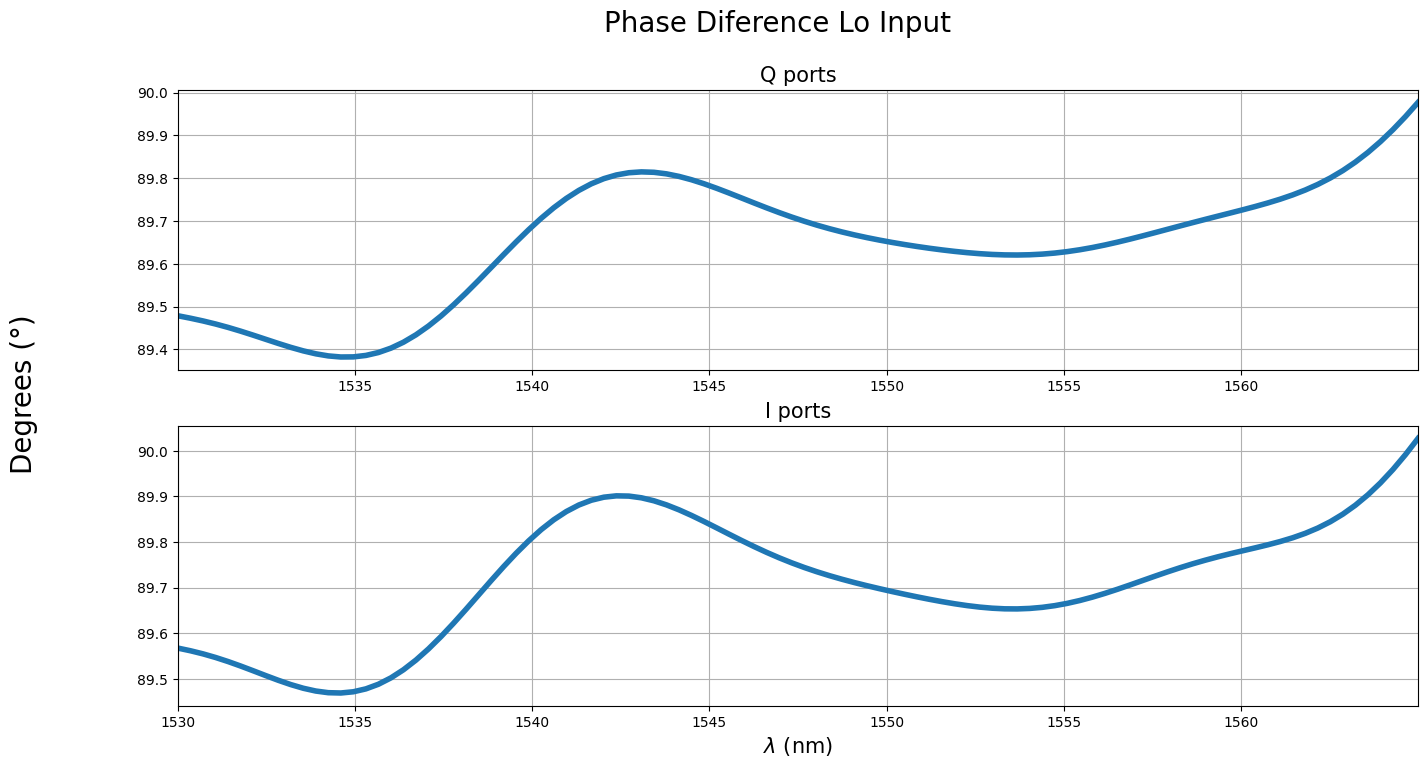

In [35]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,100)

figure14.suptitle('Phase Diference Lo Input', size = 20)


fig[0].plot(wavelength, Lo[2][1] - Lo[2][2] ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength,360 + (Lo[2][3] - Lo[2][4]) ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

figure14.supylabel('Degrees (°)', size = 20)
plt.savefig('../Documentation/Figures/Phase_Diference_Hybrid_Lo')

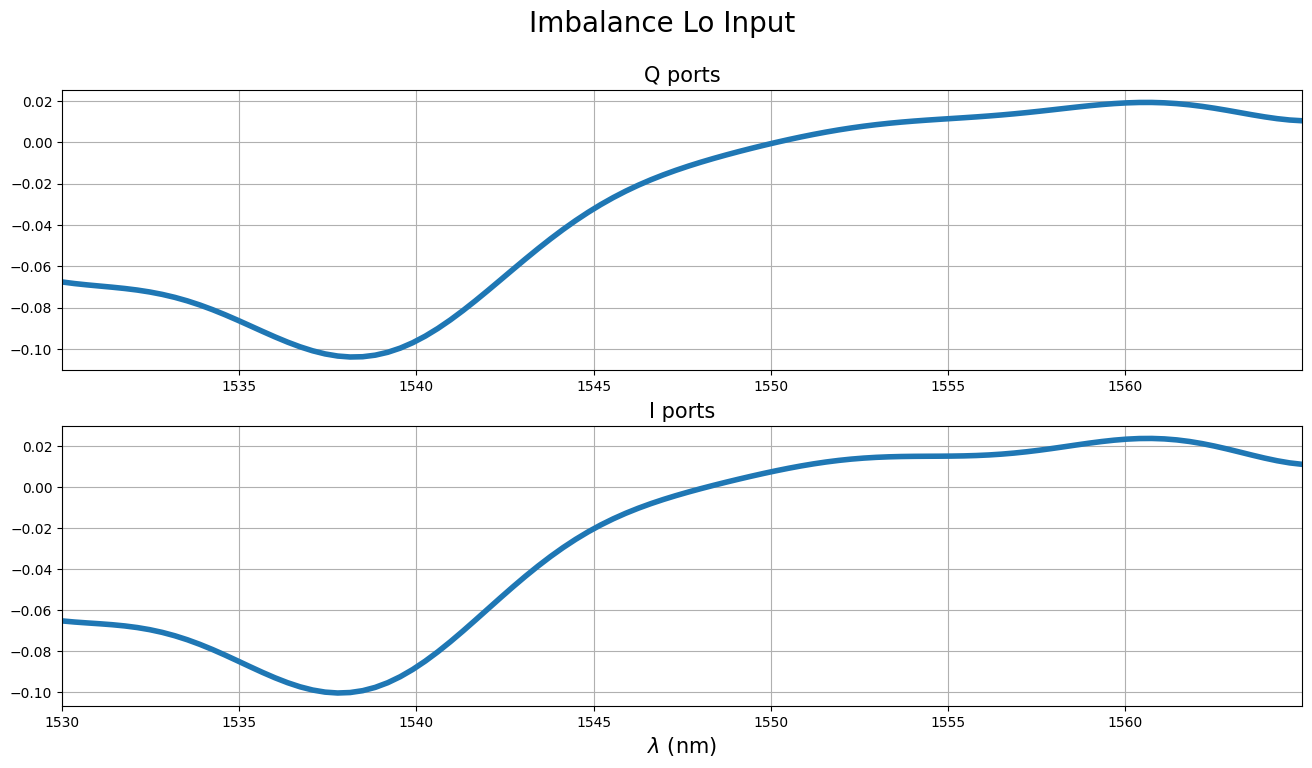

In [48]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

# In this cell, i use inbalance function created on the first cell for convinience 

wavelength = np.linspace(1530,1565,100)

figure14.suptitle('Imbalance Lo Input', size = 20)

fig[0].plot(wavelength, imbalance(Lo[0][1], Lo[0][2]) ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength, imbalance(Lo[0][3], Lo[0][4]) ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

plt.savefig('../Documentation/Figures/Imbalance_Hybrid_Lo')

Signal Input Results

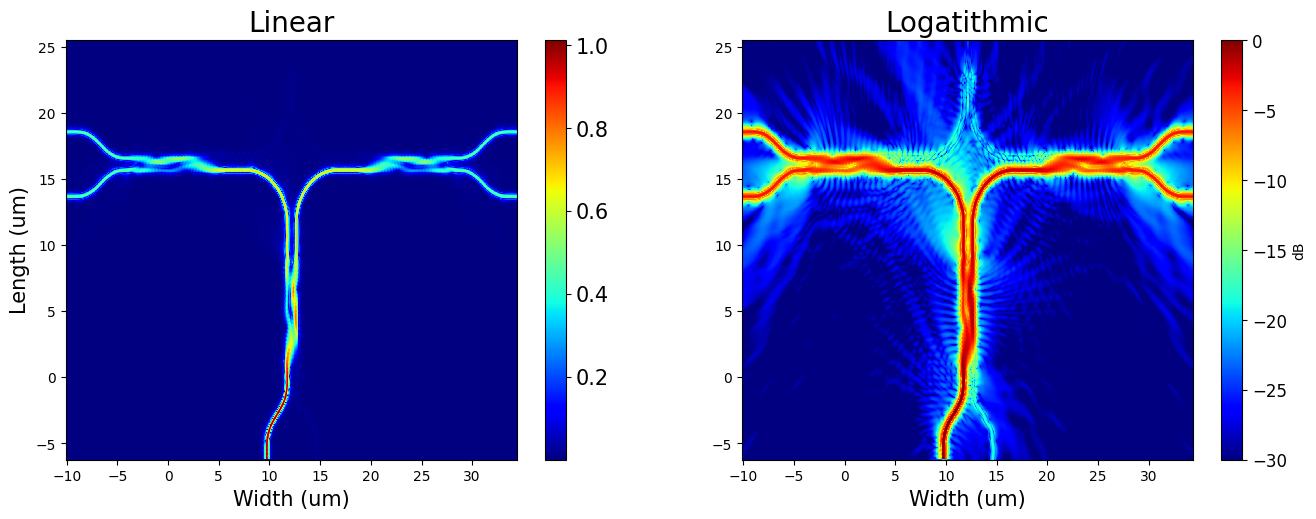

In [8]:
# Plot Linear Field Monitor Graph

figure15 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = fdtd.getresult('monitor','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Width (um)',fontsize=15)
plt.ylabel('Length (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30)
plt.xlabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Hybrid_Signal')

In [5]:
 # Getting results
S1 = fdtd.getresult('FDTD::ports::port 1', 'T')
S2 = fdtd.getresult('FDTD::ports::port 2', 'T')
S3 = fdtd.getresult('FDTD::ports::port 3', 'T')
S4 = fdtd.getresult('FDTD::ports::port 4', 'T')
S5 = fdtd.getresult('FDTD::ports::port 5', 'T')
S6 = fdtd.getresult('FDTD::ports::port 6', 'T') 
S7 = fdtd.getresult('FDTD::ports::port 7', 'T') 


T1 = abs(S1['T'])
T1log = 10*np.log10(T1) 
T2 = abs(S2['T']) # Ch-2, Qn
T2log = 10*np.log10(T2)
T3 = abs(S3['T']) # Ch-1, Qp
T3log = 10*np.log10(T3)
T4 = abs(S4['T']) # Ch-3, In
T4log = 10*np.log10(T4)
T5 = abs(S5['T']) # Ch-4, Ip
T5log = 10*np.log10(T5)
T6 = abs(S6['T']) # Input Signal
T6log = 10*np.log10(T6)
T7 = abs(S7['T'])
T7log = 10*np.log10(T7)

S1 = fdtd.getresult('FDTD::ports::port 1','S')
Phase1 = fdtd.angle(S1['S'])
P1 = fdtd.unwrap(Phase1)*180/(np.pi)

S2 = fdtd.getresult('FDTD::ports::port 2','S')
Phase2 = fdtd.angle(S2['S'])
P2 = fdtd.unwrap(Phase2)*180/(np.pi)

S3 = fdtd.getresult('FDTD::ports::port 3','S')
Phase3 = fdtd.angle(S3['S'])
P3 = fdtd.unwrap(Phase3)*180/(np.pi)

S4 = fdtd.getresult('FDTD::ports::port 4','S')
Phase4 = fdtd.angle(S4['S'])
P4 = fdtd.unwrap(Phase4)*180/(np.pi)

S5 = fdtd.getresult('FDTD::ports::port 5','S')
Phase5 = fdtd.angle(S5['S'])
P5 = fdtd.unwrap(Phase5)*180/(np.pi)

S6 = fdtd.getresult('FDTD::ports::port 6','S')
Phase6 = fdtd.angle(S6['S'])
P6 = fdtd.unwrap(Phase6)*180/(np.pi)

S7 = fdtd.getresult('FDTD::ports::port 7','S')
Phase7 = fdtd.angle(S7['S'])
P7 = fdtd.unwrap(Phase7)*180/(np.pi)

In [6]:
pointResults = [[T1,T2, T3, T4, T5, T6, T7],
                    [T1log,T2log, T3log, T4log, T5log, T6log, T7log],
                    [P1, P2, P3, P4, P5, P6, P7]
                ]

completeName = os.path.join('SavedData/','Hybrid_Signal_save.txt') # Saving the Transmission, Gain and Phase of the simulations
MSOutfile = open(completeName,'wb') 
plk.dump(pointResults,MSOutfile)
MSOutfile.close

<function BufferedWriter.close>

In [17]:
file = open("SavedData/Hybrid_Signal_save.txt",'rb') # Read the saved .txt
Signal = plk.load(file)
file.close()

#print(data)
dataFrame = pd.DataFrame(Signal)
dataFrame

,0,1,2,3,4,5,6
0,"[0.0002518113126193876, 0.00024701010118961, 0...","[0.2287208493767526, 0.2290143078937608, 0.229...","[0.23307474876405024, 0.2333118647115771, 0.23...","[0.2268541270511631, 0.22700319547903622, 0.22...","[0.2300984790854895, 0.23033479933154613, 0.23...","[0.9995616350968902, 0.9995721890504861, 0.999...","[0.000413068253293794, 0.0004057964148368547, ..."
1,"[-35.989247631168936, -36.07285286411554, -36....","[-6.406942448529716, -6.401373838382951, -6.39...","[-6.325047752416054, -6.320631752750565, -6.31...","[-6.442533154094575, -6.439680292864161, -6.43...","[-6.38086251939624, -6.376404432083808, -6.372...","[-0.0019042119851575574, -0.001858356887778744...","[-33.83978181806595, -33.916917942259076, -33...."
2,"[[-112.34149267954842], [-95.19855321249302], ...","[[154.70411613103727], [163.9287145511754], [1...","[[-115.42396021815966], [-106.2016346725122], ...","[[-169.96701992108655], [-160.75899960973948],...","[[-81.4395316455552], [-72.21410570162895], [-...","[[14.829177205477531], [21.9953901282845], [29...","[[-154.956909727054], [-143.45280539673183], [..."


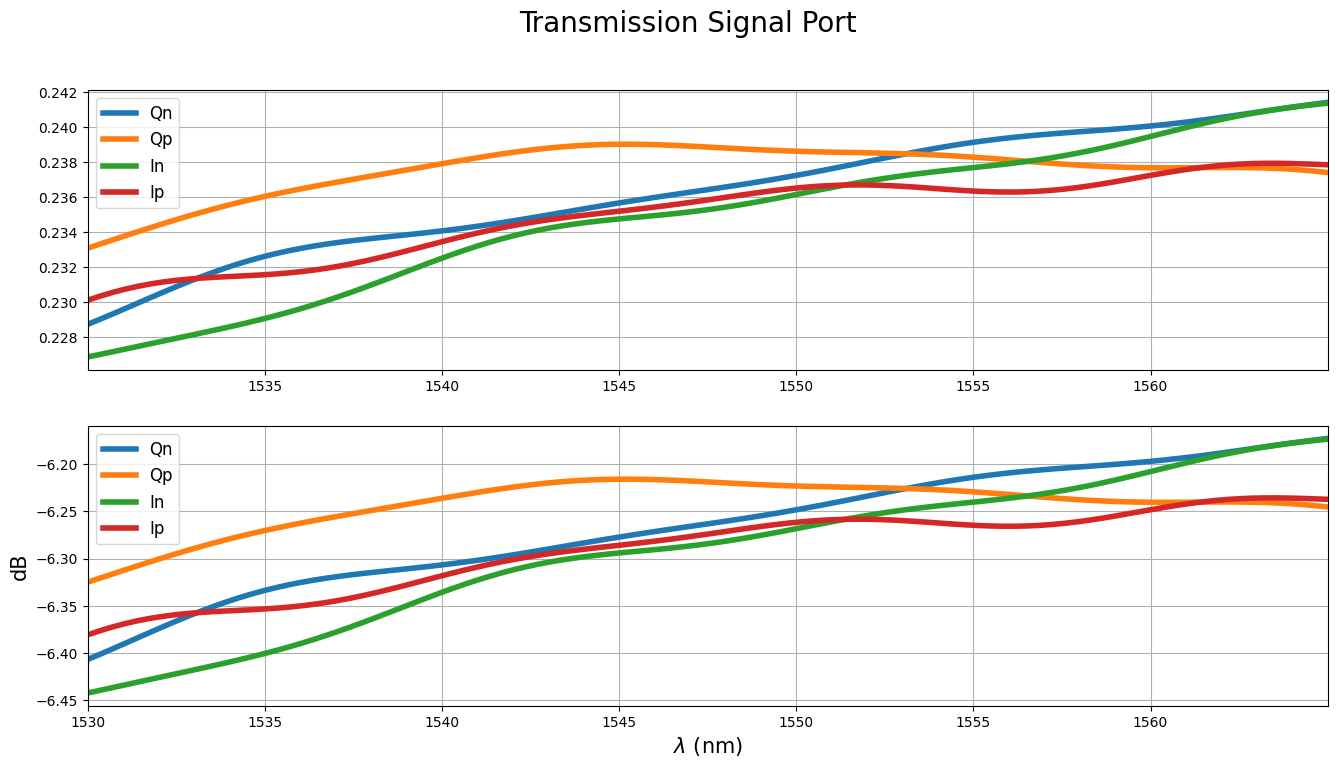

In [5]:
figure16, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530, 1565, 100)

figure16.suptitle('Transmission Signal Port', size = 20)


fig[0].plot(wavelength, Signal[0][1],linewidth = 4, label = 'Qn')
fig[0].plot(wavelength, Signal[0][2], linewidth = 4, label = 'Qp')
fig[0].plot(wavelength, Signal[0][3],linewidth = 4, label = 'In')
fig[0].plot(wavelength, Signal[0][4], linewidth = 4, label = 'Ip')
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].legend(fontsize = 12)
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength, Signal[1][1],linewidth = 4, label = 'Qn')
fig[1].plot(wavelength, Signal[1][2], linewidth = 4, label = 'Qp')
fig[1].plot(wavelength, Signal[1][3],linewidth = 4, label = 'In')
fig[1].plot(wavelength, Signal[1][4], linewidth = 4, label = 'Ip')
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_xlim(1530,1565)
fig[1].legend(fontsize = 12)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)
fig[1].set_ylabel('dB', size = 15)
plt.savefig('../Documentation/Figures/Transmission_Hybrid_Signal')

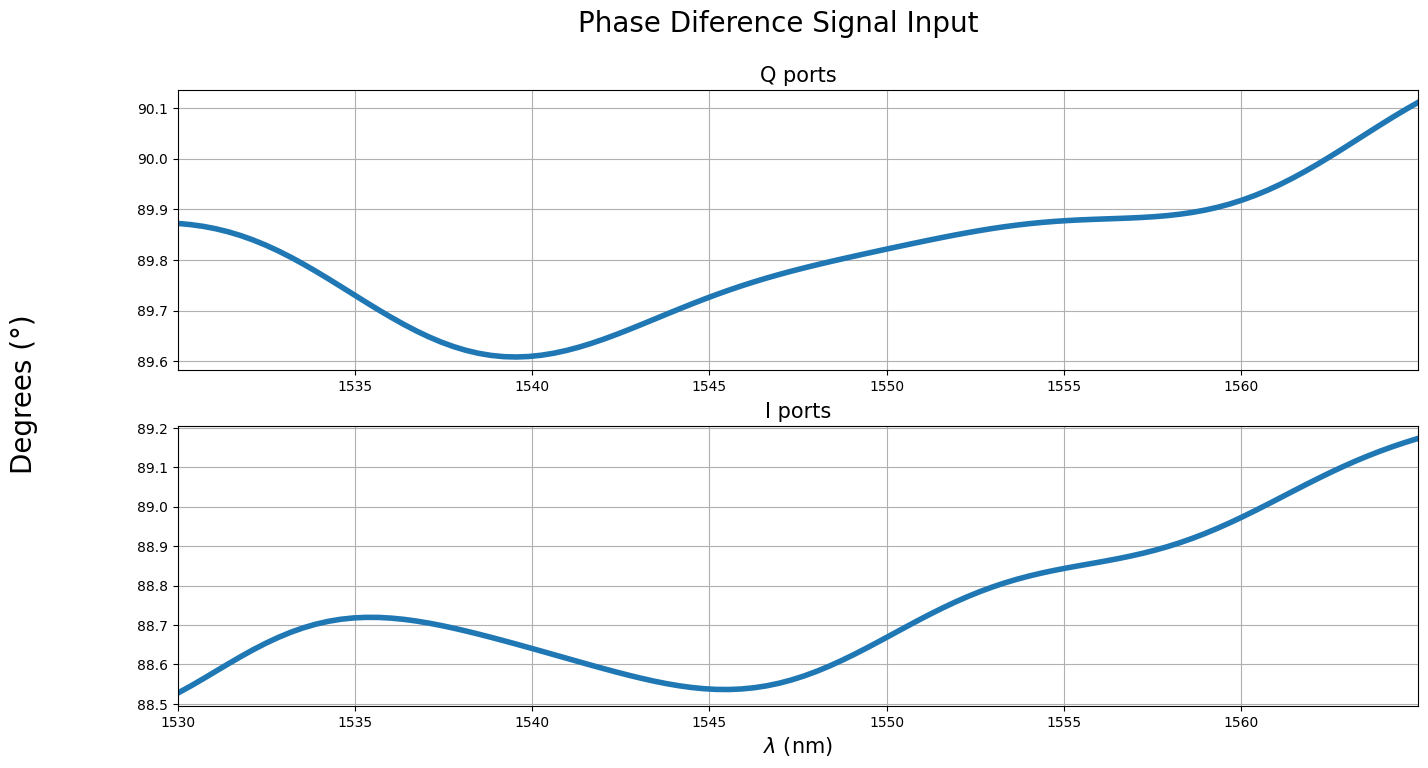

In [39]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,100)

figure14.suptitle('Phase Diference Signal Input', size = 20)


fig[0].plot(wavelength,360 -(Signal[2][1] - Signal[2][2]) ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength, -Signal[2][3] + Signal[2][4] ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

figure14.supylabel('Degrees (°)', size = 20)
plt.savefig('../Documentation/Figures/Phase_Diference_Hybrid_Signal')

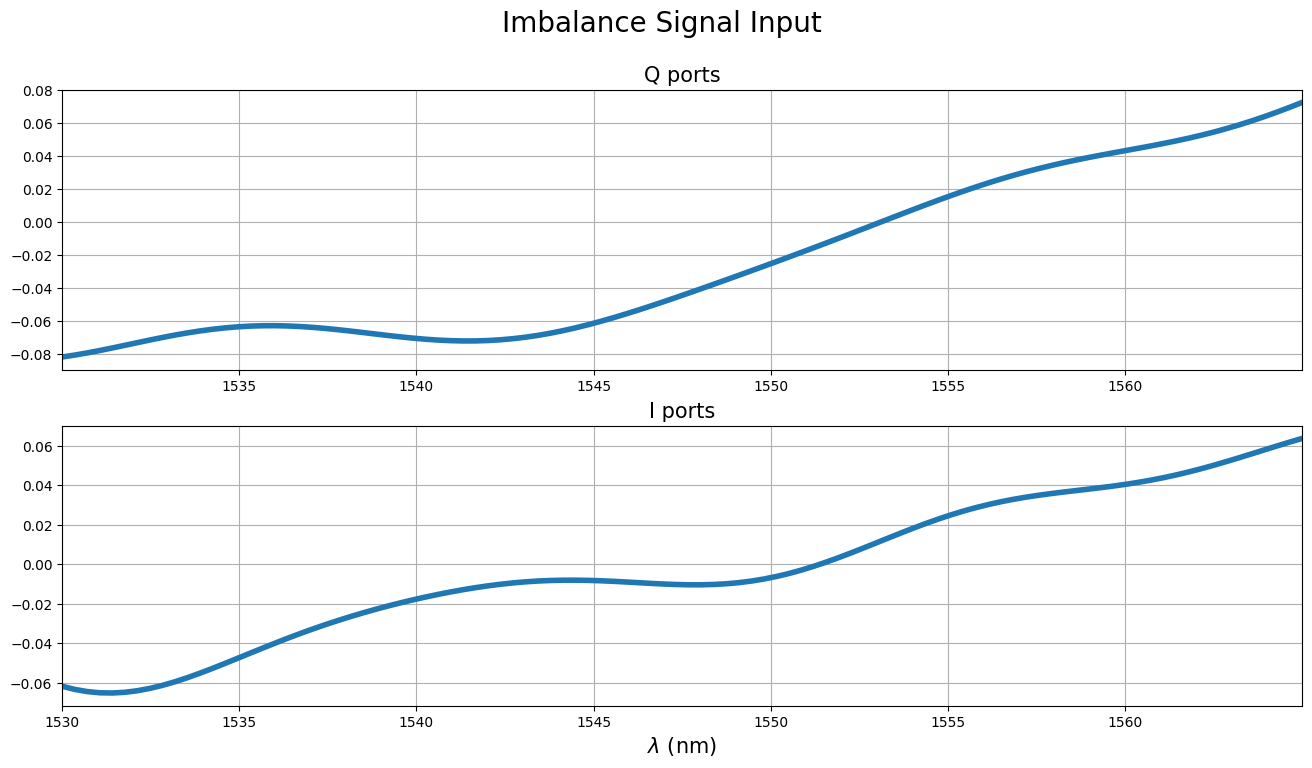

In [18]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,100)

figure14.suptitle('Imbalance Signal Input', size = 20)

fig[0].plot(wavelength, imbalance(Signal[0][2], Signal[0][1]) ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength, imbalance(Signal[0][4], Signal[0][3]) ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

plt.savefig('../Documentation/Figures/Imbalance_Hybrid_Signal')

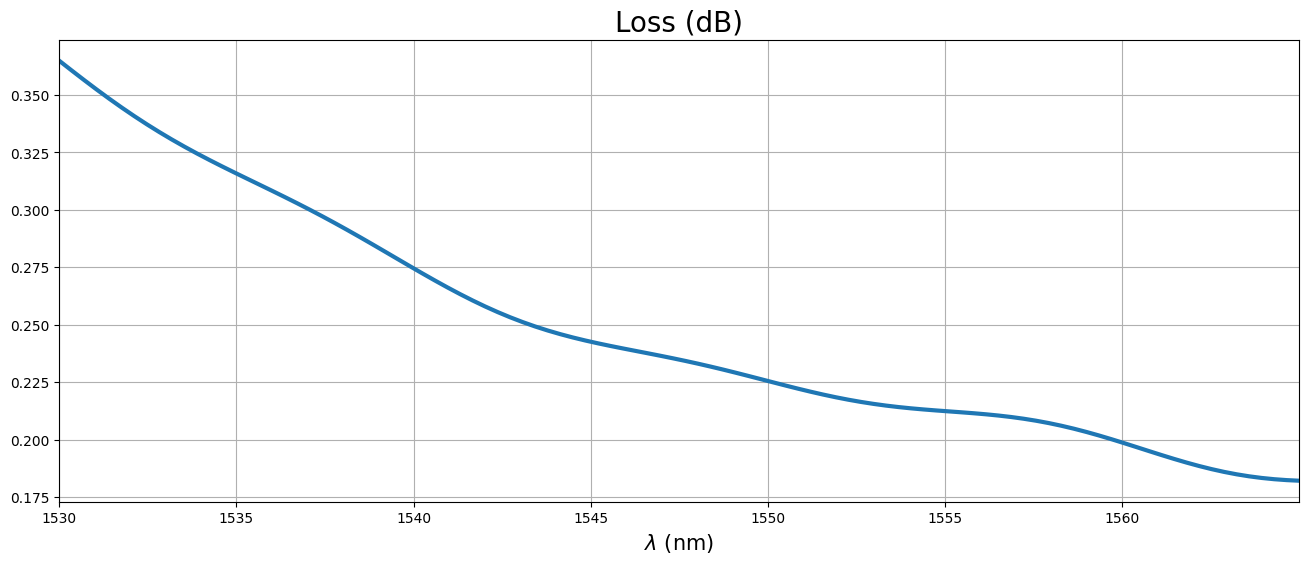

In [4]:
figure17 = plt.figure(figsize = (16,6))
wavelength = np.transpose(np.linspace(1530,1565,100))

Loss = -10*np.log10(Signal[0][1]+Signal[0][2]+Signal[0][3]+Signal[0][4]+Signal[0][0]+Signal[0][6])

plt.plot(wavelength, Loss, linewidth = 3)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('Loss (dB)', size = 20)
plt.savefig('../Documentation/Figures/Loss_Hybrid_Signal')

CMRR Plot

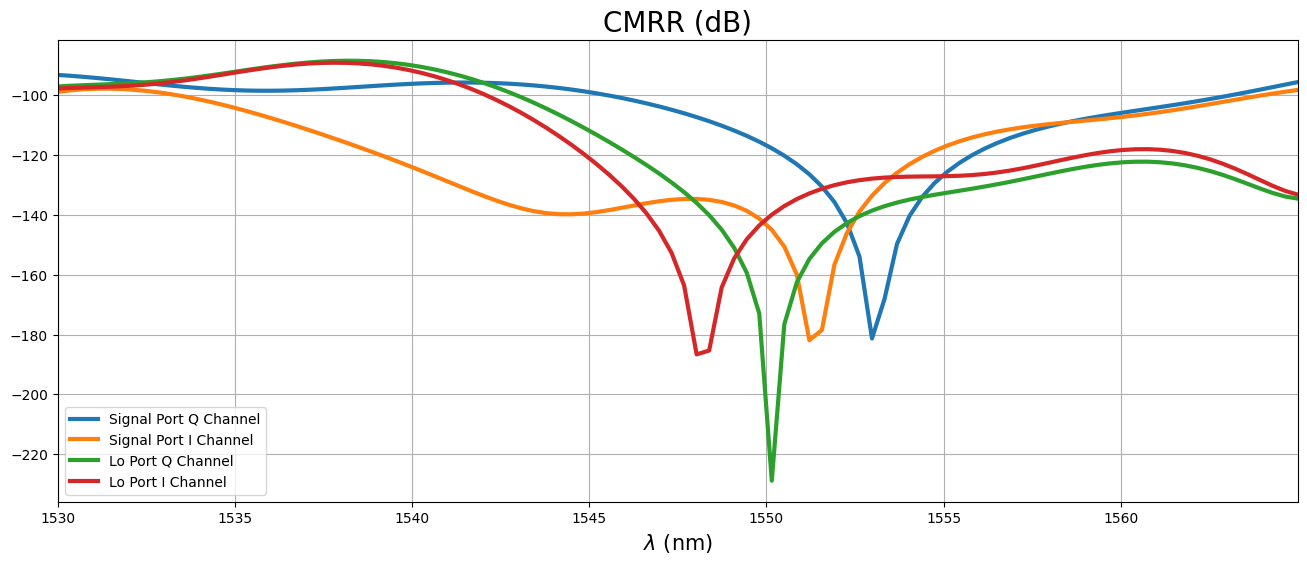

In [63]:
figure10 = plt.figure(figsize = (16,6))

# In this cell, i use CMRR function created on the first cell for convinience 

CMRR_S_Q = CMRR(Signal[0][1], Signal[0][2])
CMRR_S_I = CMRR(Signal[0][3], Signal[0][4])

CMRR_Lo_Q = CMRR(Lo[0][1], Lo[0][2])
CMRR_Lo_I = CMRR(Lo[0][3], Lo[0][4])

plt.plot(wavelength, CMRR_S_Q, linewidth = 3, label = 'Signal Port Q Channel')
plt.plot(wavelength, CMRR_S_I, linewidth = 3, label = 'Signal Port I Channel')
plt.plot(wavelength, CMRR_Lo_Q, linewidth = 3, label = 'Lo Port Q Channel')
plt.plot(wavelength, CMRR_Lo_I, linewidth = 3, label = 'Lo Port I Channel')

plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.legend()
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('CMRR (dB)', size = 20)

plt.savefig('../Documentation/Figures/CMRR_Hybrid')

Interconnect

In [3]:
icp = lumapi.INTERCONNECT('../CML/Hybrid_INTERCONNECT.icp')

In [9]:
icp.addelement("Optical Network Analyzer") # Creating analyzer
icp.set("name", "ONA_1")
icp.set("number of input ports", 7)
icp.set("input parameter", "start and stop")
icp.set("start frequency", c0/Cband[0])
icp.set("stop frequency", c0/Cband[-1])
icp.set("number of points", 5e5)

In [8]:
for i in range(4): # Creating the bends
    icp.addelement('Optical N Port S-parameter')
    icp.set("load from file", True)
    icp.set("s parameters filename", "../CML/Exports/Bend_Export.dat")
    icp.set('name', 'Bend' + str(i+1))

In [10]:
for i in range(5): # Creating MMIs
    icp.addelement('Optical N Port S-parameter')
    icp.set("load from file", True)
    icp.set("s parameters filename", "../CML/Exports/MMI_2x2_Export.dat")
    icp.set('name', 'MMI'+ str(i+1))

In [11]:
icp.addelement('Optical N Port S-parameter') # Creating Y-Branch
icp.set("load from file", True)
icp.set("s parameters filename", "../CML/Exports/Y-Branch_Export.dat")
icp.set('name', 'Y-Branch')

In [28]:
 # Getting results Lo
Lo1 = icp.getresult('ONA_1', 'input 1/mode 1/transmission')
wavelength = Lo1['wavelength']
Lo1 = Lo1['mode 1 transmission']
Lo1log = 10*np.log10(Lo1)
Lo1 = abs(Lo1)**2

Lo2 = icp.getresult('ONA_1', 'input 2/mode 1/transmission')# Ch-2, Qn
Lo2 = Lo2['mode 1 transmission']
Lo2log = 10*np.log10(Lo2)
Lo2 = abs(Lo2)**2

Lo3 = icp.getresult('ONA_1', 'input 3/mode 1/transmission')# Ch-1, Qp
Lo3 = Lo3['mode 1 transmission']
Lo3log = 10*np.log10(Lo3)
Lo3 = abs(Lo3)**2

Lo4 = icp.getresult('ONA_1', 'input 4/mode 1/transmission')# Ch-3, In
Lo4 = Lo4['mode 1 transmission']
Lo4log = 10*np.log10(Lo4)
Lo4 = abs(Lo4)**2

Lo5 = icp.getresult('ONA_1', 'input 5/mode 1/transmission')# Ch-4, Ip
Lo5 = Lo5['mode 1 transmission']
Lo5log = 10*np.log10(Lo5)
Lo5 = abs(Lo5)**2

Lo6 = icp.getresult('ONA_1', 'input 6/mode 1/transmission')# Input Signal
Lo6 = Lo6['mode 1 transmission']
Lo6log = 10*np.log10(Lo6)
Lo6 = abs(Lo6)**2

Lo7 = icp.getresult('ONA_1', 'input 7/mode 1/transmission')
Lo7 = Lo7['mode 1 transmission']
Lo7log = 10*np.log10(Lo7)
Lo7 = abs(Lo7)**2

S1 = icp.getresult('ONA_1', 'input 1/mode 1/angle')
Phase1 = icp.angle(S1['mode 1 angle (rad)'])
P1Lo = icp.unwrap(Phase1)*180/(np.pi)

S2 = icp.getresult('ONA_1', 'input 2/mode 1/angle')
Phase2 = icp.angle(S2['mode 1 angle (rad)'])
P2Lo = icp.unwrap(Phase2)*180/(np.pi)

S3 = icp.getresult('ONA_1', 'input 3/mode 1/angle')
Phase3 = icp.angle(S3['mode 1 angle (rad)'])
P3Lo = icp.unwrap(Phase3)*180/(np.pi)

S4 = icp.getresult('ONA_1', 'input 4/mode 1/angle')
Phase4 = icp.angle(S4['mode 1 angle (rad)'])
P4Lo = icp.unwrap(Phase4)*180/(np.pi)

S5 = icp.getresult('ONA_1', 'input 5/mode 1/angle')
Phase5 = icp.angle(S5['mode 1 angle (rad)'])
P5Lo = icp.unwrap(Phase5)*180/(np.pi)

S6 = icp.getresult('ONA_1', 'input 6/mode 1/angle')
Phase6 = icp.angle(S6['mode 1 angle (rad)'])
P6Lo = icp.unwrap(Phase6)*180/(np.pi)

S7 = icp.getresult('ONA_1', 'input 7/mode 1/angle')
Phase7 = icp.angle(S7['mode 1 angle (rad)'])
P7Lo = icp.unwrap(Phase7)*180/(np.pi)

In [33]:
 # Getting results Signal

Sig1 = icp.getresult('ONA_1', 'input 2/mode 1/transmission')# Ch-2, Qn
Sig1 = Sig1['mode 1 transmission']
Sig1log = 10*np.log10(Sig1)
Sig1 = abs(Sig1)**2

Sig2 = icp.getresult('ONA_1', 'input 2/mode 1/transmission')# Ch-2, Qn
Sig2 = Sig2['mode 1 transmission']
Sig2log = 10*np.log10(Sig2)
Sig2 = abs(Sig2)**2

Sig3 = icp.getresult('ONA_1', 'input 3/mode 1/transmission')# Ch-1, Qp
Sig3 = Sig3['mode 1 transmission']
Sig3log = 10*np.log10(Sig3)
Sig3 = abs(Sig3)**2

Sig4 = icp.getresult('ONA_1', 'input 4/mode 1/transmission')# Ch-3, In
Sig4 = Sig4['mode 1 transmission']
Sig4log = 10*np.log10(Sig4)
Sig4 = abs(Sig4)**2

Sig5 = icp.getresult('ONA_1', 'input 5/mode 1/transmission')# Ch-4, Ip
Sig5 = Sig5['mode 1 transmission']
Sig5log = 10*np.log10(Sig5)
Sig5 = abs(Sig5)**2

Sig6 = icp.getresult('ONA_1', 'input 6/mode 1/transmission')# Input Signal
Sig6 = Sig6['mode 1 transmission']
Sig6log = 10*np.log10(Sig6)
Sig6 = abs(Sig6)**2

Sig7 = icp.getresult('ONA_1', 'input 7/mode 1/transmission')
Sig7 = Sig7['mode 1 transmission']
Sig7log = 10*np.log10(Sig7)
Sig7 = abs(Sig7)**2

S1 = icp.getresult('ONA_1', 'input 1/mode 1/angle')
Phase1 = icp.angle(S1['mode 1 angle (rad)'])
P1S = icp.unwrap(Phase1)*180/(np.pi)

S2 = icp.getresult('ONA_1', 'input 2/mode 1/angle')
Phase2 = icp.angle(S2['mode 1 angle (rad)'])
P2S = icp.unwrap(Phase2)*180/(np.pi)

S3 = icp.getresult('ONA_1', 'input 3/mode 1/angle')
Phase3 = icp.angle(S3['mode 1 angle (rad)'])
P3S = icp.unwrap(Phase3)*180/(np.pi)

S4 = icp.getresult('ONA_1', 'input 4/mode 1/angle')
Phase4 = icp.angle(S4['mode 1 angle (rad)'])
P4S = icp.unwrap(Phase4)*180/(np.pi)

S5 = icp.getresult('ONA_1', 'input 5/mode 1/angle')
Phase5 = icp.angle(S5['mode 1 angle (rad)'])
P5S = icp.unwrap(Phase5)*180/(np.pi)

S6 = icp.getresult('ONA_1', 'input 6/mode 1/angle')
Phase6 = icp.angle(S6['mode 1 angle (rad)'])
P6S = icp.unwrap(Phase6)*180/(np.pi)

S7 = icp.getresult('ONA_1', 'input 7/mode 1/angle')
Phase7 = icp.angle(S7['mode 1 angle (rad)'])
P7S = icp.unwrap(Phase7)*180/(np.pi)

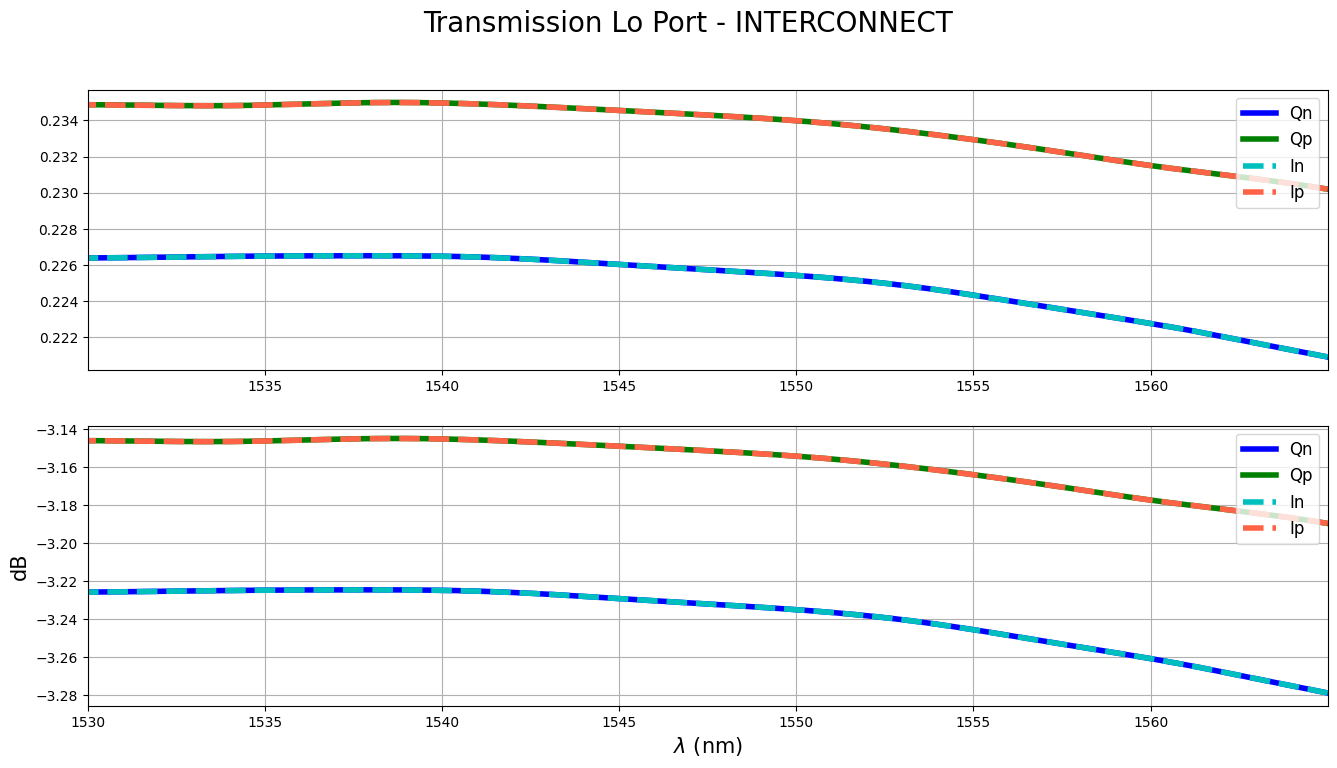

In [29]:
figure18, fig = plt.subplots(2,1,figsize=(16,8))

figure18.suptitle('Transmission Lo Port - INTERCONNECT', size = 20)


fig[0].plot(wavelength*1e9, Lo2,linewidth = 4, label = 'Qn', color = 'b')
fig[0].plot(wavelength*1e9, Lo3, linewidth = 4, label = 'Qp', color = 'g')
fig[0].plot(wavelength*1e9, Lo4,'--',linewidth = 4, label = 'In', color = 'c')
fig[0].plot(wavelength*1e9, Lo5,'--', linewidth = 4, label = 'Ip', color = 'tomato')
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].legend(fontsize = 12)
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength*1e9, Lo2log,linewidth = 4, label = 'Qn', color = 'b')
fig[1].plot(wavelength*1e9, Lo3log, linewidth = 4, label = 'Qp', color = 'g')
fig[1].plot(wavelength*1e9, Lo4log,'--',linewidth = 4, label = 'In', color = 'c')
fig[1].plot(wavelength*1e9, Lo5log,'--', linewidth = 4, label = 'Ip', color = 'tomato')
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_xlim(1530,1565)
fig[1].legend(fontsize = 12)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)
fig[1].set_ylabel('dB', size = 15)
plt.savefig('../Documentation/Figures/Transmission_Hybrid_Lo-INTERCONNECT')

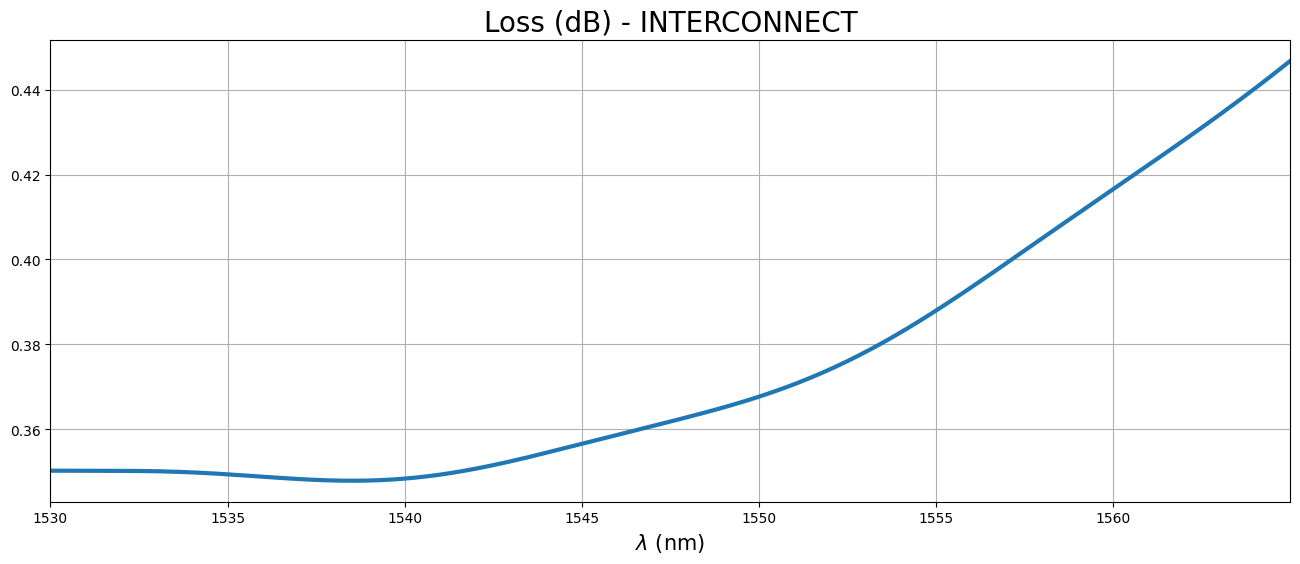

In [30]:
figure199 = plt.figure(figsize = (16,6))

Loss = -10*np.log10(Lo2+Lo3+Lo4+Lo5+Lo6+Lo7)

plt.plot(wavelength*1e9, Loss, linewidth = 3)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('Loss (dB) - INTERCONNECT', size = 20)
plt.savefig('../Documentation/Figures/Loss_Hybrid_Lo-INTERCONNECT') 

In [7]:
 # Getting results
T1 = icp.getresult('ONA_1', 'input 1/mode 1/transmission')
T1 = T1['mode 1 transmission']
T1log = 10*np.log10(T1)
T1 = abs(T1)**2

T2 = icp.getresult('ONA_1', 'input 2/mode 1/transmission')# Ch-2, Qn
T2 = T2['mode 1 transmission']
T2log = 10*np.log10(T2)
T2 = abs(T2)**2

T3 = icp.getresult('ONA_1', 'input 3/mode 1/transmission')# Ch-1, Qp
T3 = T3['mode 1 transmission']
T3log = 10*np.log10(T3)
T3 = abs(T3)**2

T4 = icp.getresult('ONA_1', 'input 4/mode 1/transmission')# Ch-3, In
T4 = T4['mode 1 transmission']
T4log = 10*np.log10(T4)
T4 = abs(T4)**2

T5 = icp.getresult('ONA_1', 'input 5/mode 1/transmission')# Ch-4, Ip
T5 = T5['mode 1 transmission']
T5log = 10*np.log10(T5)
T5 = abs(T5)**2

T6 = icp.getresult('ONA_1', 'input 6/mode 1/transmission')# Input Signal
T6 = T6['mode 1 transmission']
T6log = 10*np.log10(T6)
T6 = abs(T6)**2

T7 = icp.getresult('ONA_1', 'input 7/mode 1/transmission')
T7 = T7['mode 1 transmission']
T7log = 10*np.log10(T7)
T7 = abs(T7)**2

C:\Users\Léo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


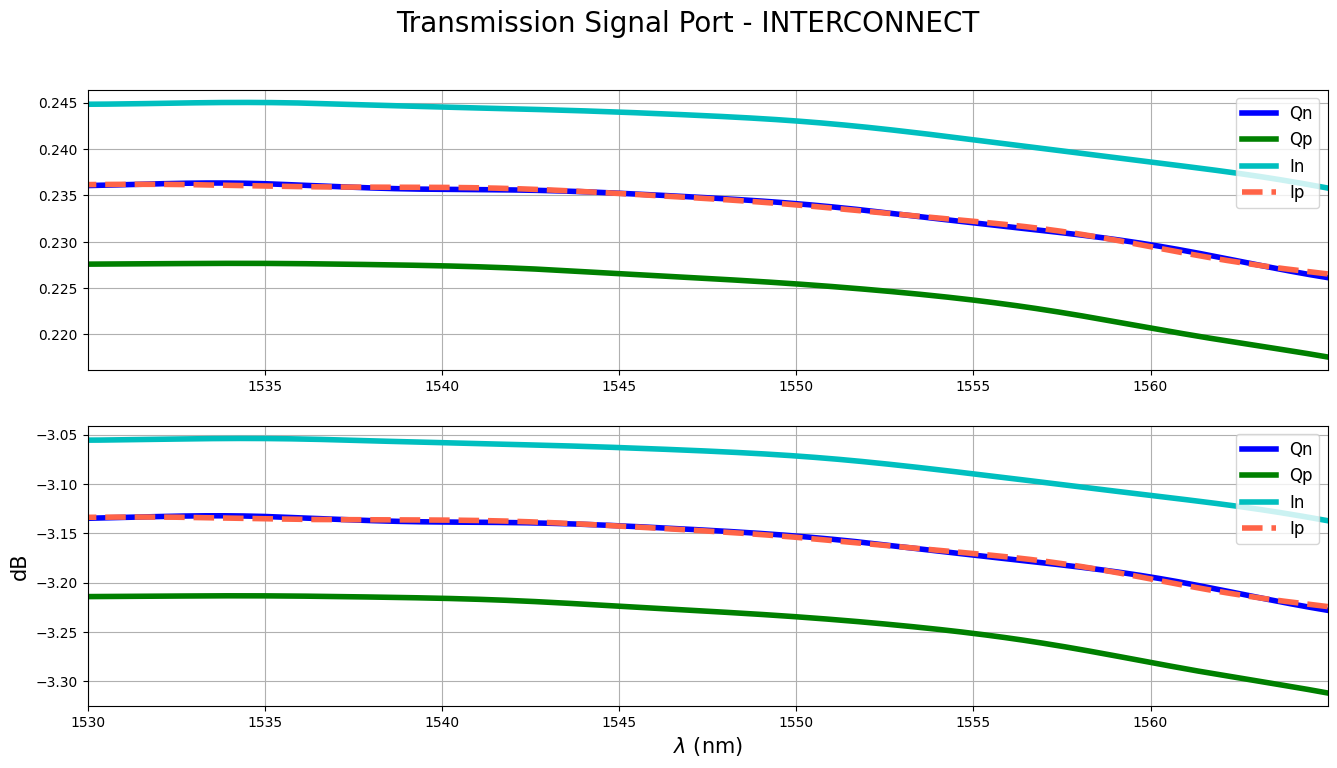

In [34]:
figure20, fig = plt.subplots(2,1,figsize=(16,8))

figure20.suptitle('Transmission Signal Port - INTERCONNECT', size = 20)


fig[0].plot(wavelength*1e9, Sig2,linewidth = 4, label = 'Qn', color = 'b')
fig[0].plot(wavelength*1e9, Sig3, linewidth = 4, label = 'Qp', color = 'g')
fig[0].plot(wavelength*1e9, Sig4,linewidth = 4, label = 'In', color = 'c')
fig[0].plot(wavelength*1e9, Sig5,'--', linewidth = 4, label = 'Ip', color = 'tomato')
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].legend(fontsize = 12)
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength*1e9, Sig2log,linewidth = 4, label = 'Qn', color = 'b')
fig[1].plot(wavelength*1e9, Sig3log, linewidth = 4, label = 'Qp', color = 'g')
fig[1].plot(wavelength*1e9, Sig4log,linewidth = 4, label = 'In', color = 'c')
fig[1].plot(wavelength*1e9, Sig5log,'--', linewidth = 4, label = 'Ip', color = 'tomato')
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_xlim(1530,1565)
fig[1].legend(fontsize = 12)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)
fig[1].set_ylabel('dB', size = 15)
plt.savefig('../Documentation/Figures/Transmission_Hybrid_Signal-INTERCONNECT')

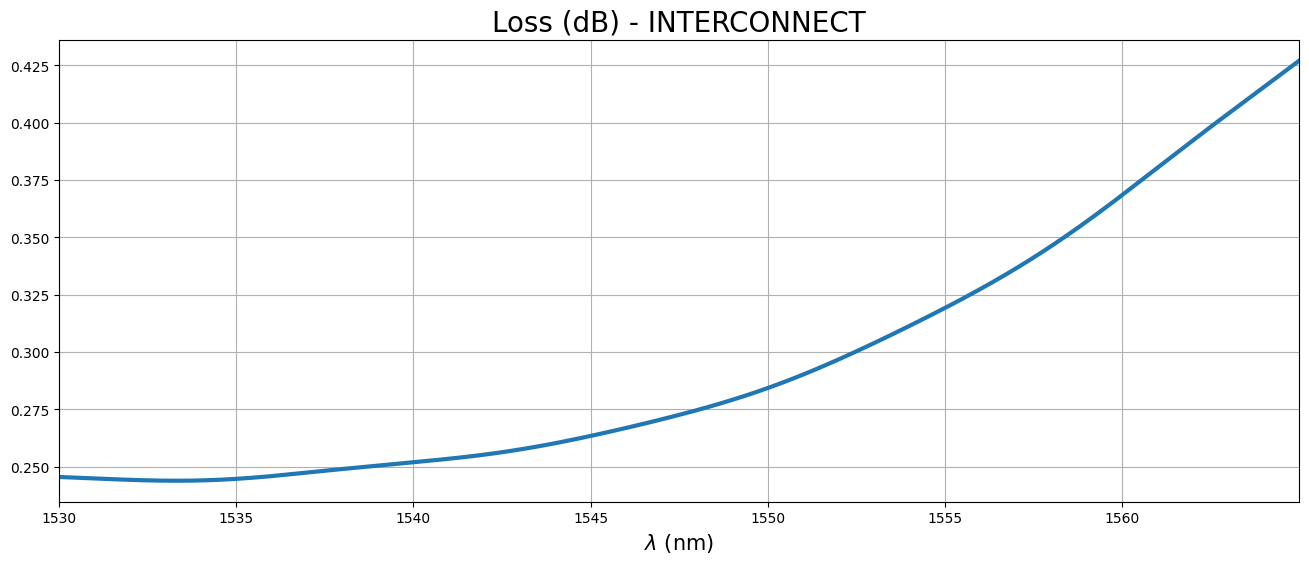

In [36]:
figure21 = plt.figure(figsize = (16,6))

Loss = -10*np.log10(Sig2+Sig3+Sig4+Sig5+Sig6+Sig7)

plt.plot(wavelength*1e9, Loss, linewidth = 3)
plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('Loss (dB) - INTERCONNECT', size = 20)
plt.savefig('../Documentation/Figures/Loss_Hybrid_Signal-INTERCONNECT') 

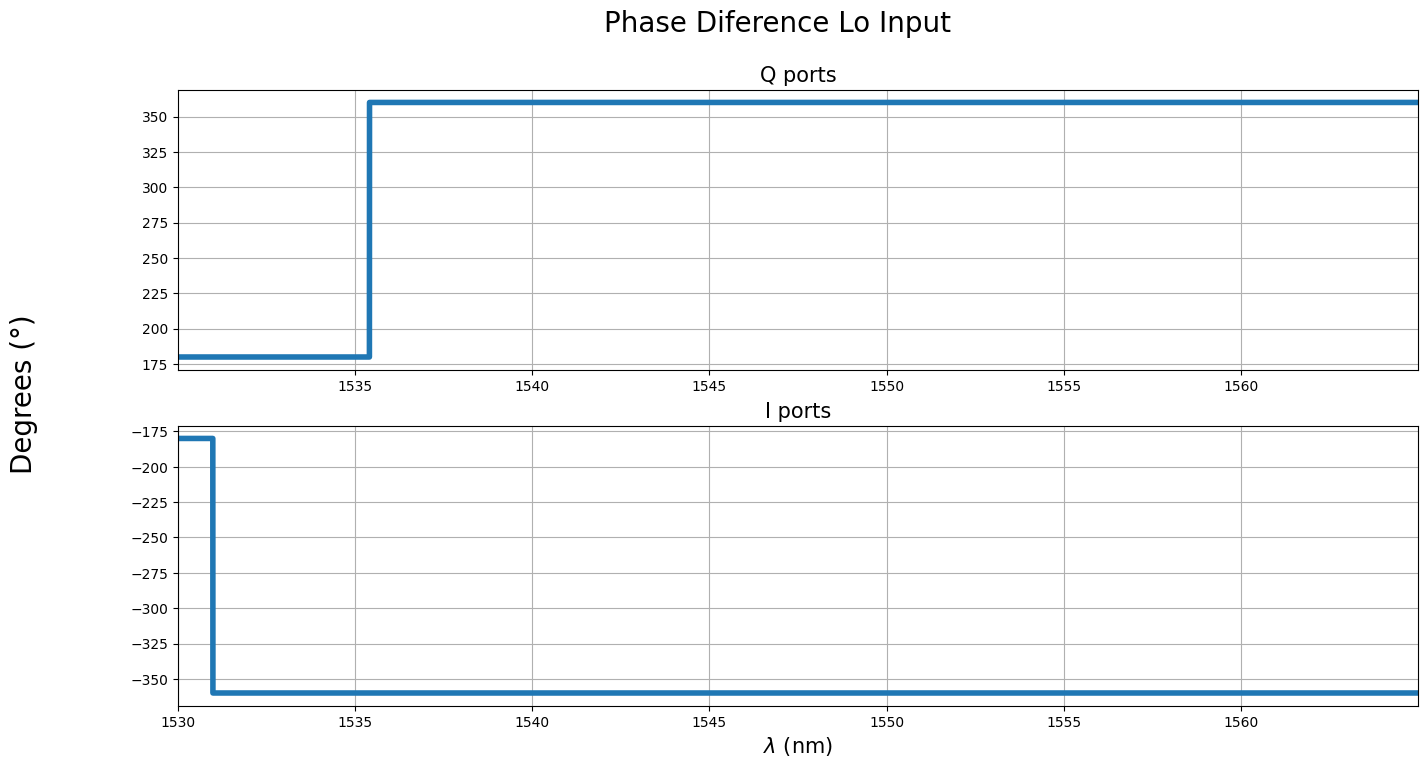

In [37]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,500000)

figure14.suptitle('Phase Diference Lo Input - INTERCONNECT', size = 20)

wavelength = np.linspace(1530,1565,500000)

figure14.suptitle('Phase Diference Lo Input', size = 20)


fig[0].plot(wavelength, P2Lo - P3Lo ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength,P4Lo - P5Lo ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

figure14.supylabel('Degrees (°)', size = 20)
plt.savefig('../Documentation/Figures/Phase_Diference_Hybrid_Lo_INTERCONNECT')

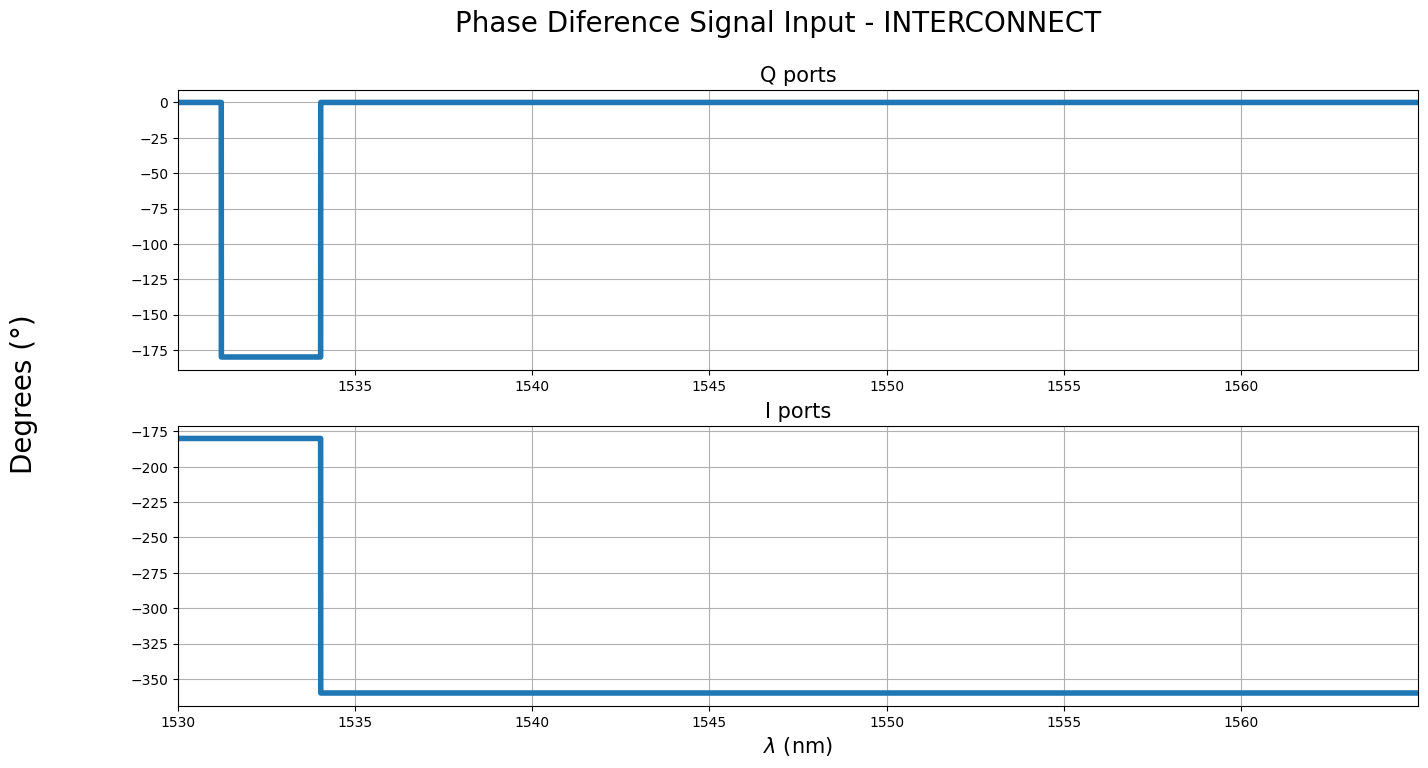

In [38]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,500000)

figure14.suptitle('Phase Diference Signal Input - INTERCONNECT', size = 20)

wavelength = np.linspace(1530,1565,500000)

fig[0].plot(wavelength, P2S - P3S ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength,P4S - P5S ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

figure14.supylabel('Degrees (°)', size = 20)
plt.savefig('../Documentation/Figures/Phase_Diference_Hybrid_Signal_INTERCONNECT')

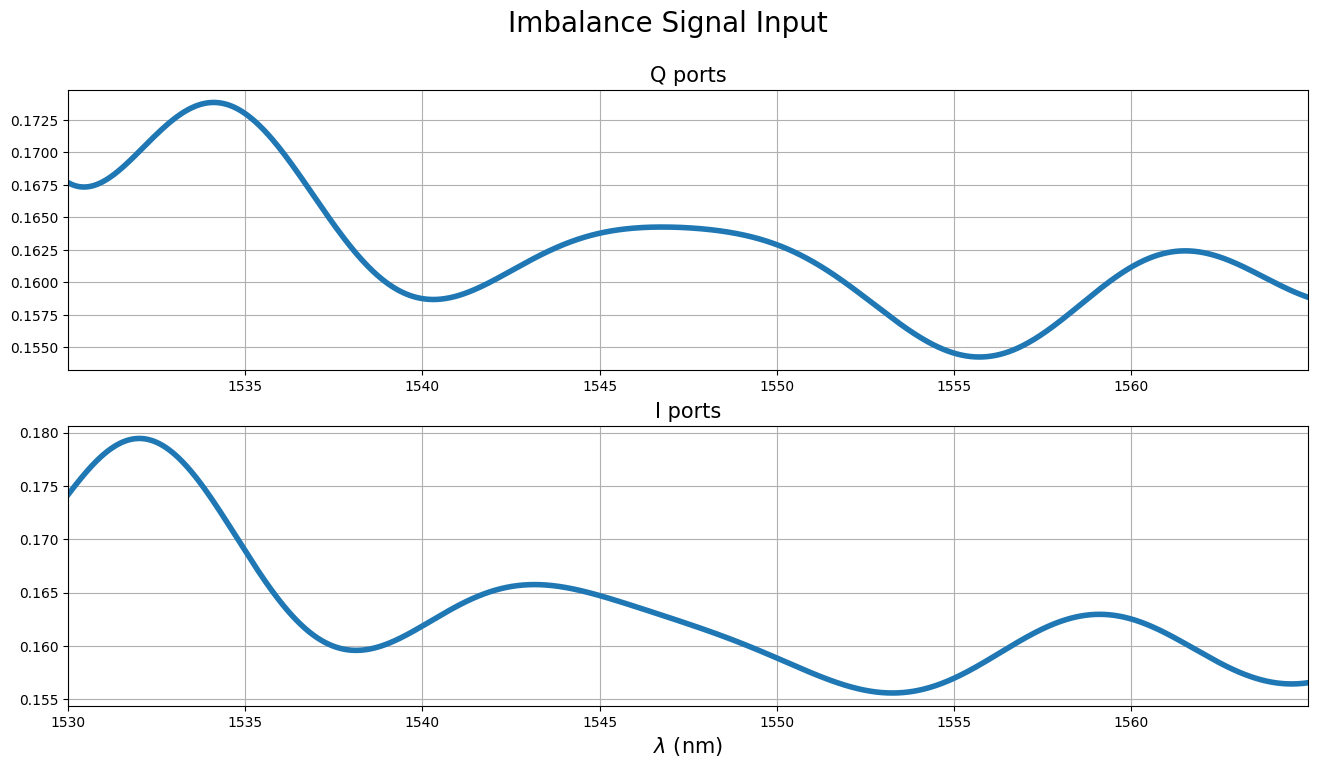

In [39]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,500000)

figure14.suptitle('Imbalance Signal Input', size = 20)

fig[0].plot(wavelength, imbalance(Sig3, Sig2) ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength, imbalance(Sig5, Sig4) ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

plt.savefig('../Documentation/Figures/Imbalance_Hybrid_Signal_INTERCONNECT')

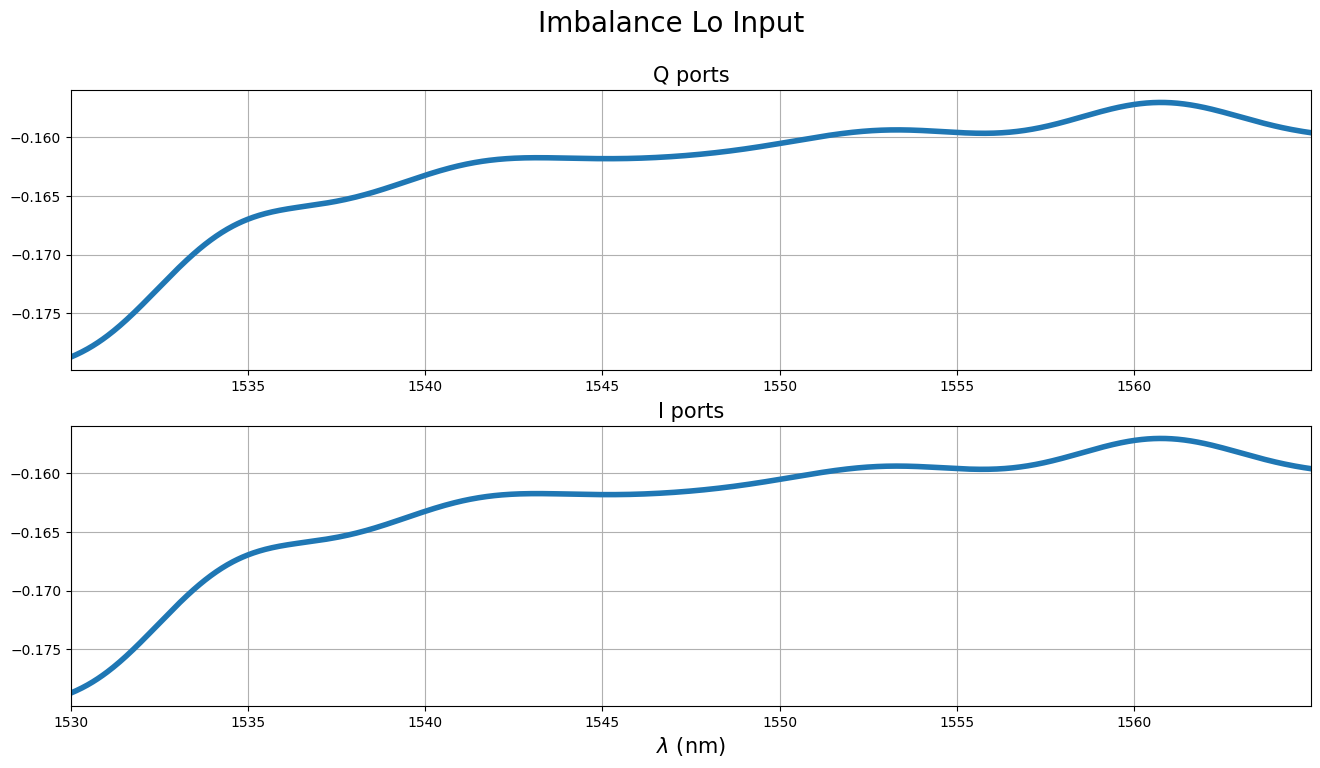

In [40]:
figure14, fig = plt.subplots(2,1,figsize=(16,8))

wavelength = np.linspace(1530,1565,500000)

figure14.suptitle('Imbalance Lo Input', size = 20)

fig[0].plot(wavelength, imbalance(Lo3, Lo2) ,linewidth = 4)
fig[0].set_title('Q ports', size = 15)
fig[0].set_xticks(np.arange(1535,1565,5))
fig[0].set_xlim(1530,1565)
fig[0].grid()

fig[1].plot(wavelength, imbalance(Lo5, Lo4) ,linewidth = 4)
fig[1].set_xticks(np.arange(1530,1565,5))
fig[1].set_title('I ports', size = 15)
fig[1].set_xlim(1530,1565)
fig[1].grid()
fig[1].set_xlabel('$\lambda$ (nm)', size = 15)

plt.savefig('../Documentation/Figures/Imbalance_Hybrid_Lo_INTERCONNECT')

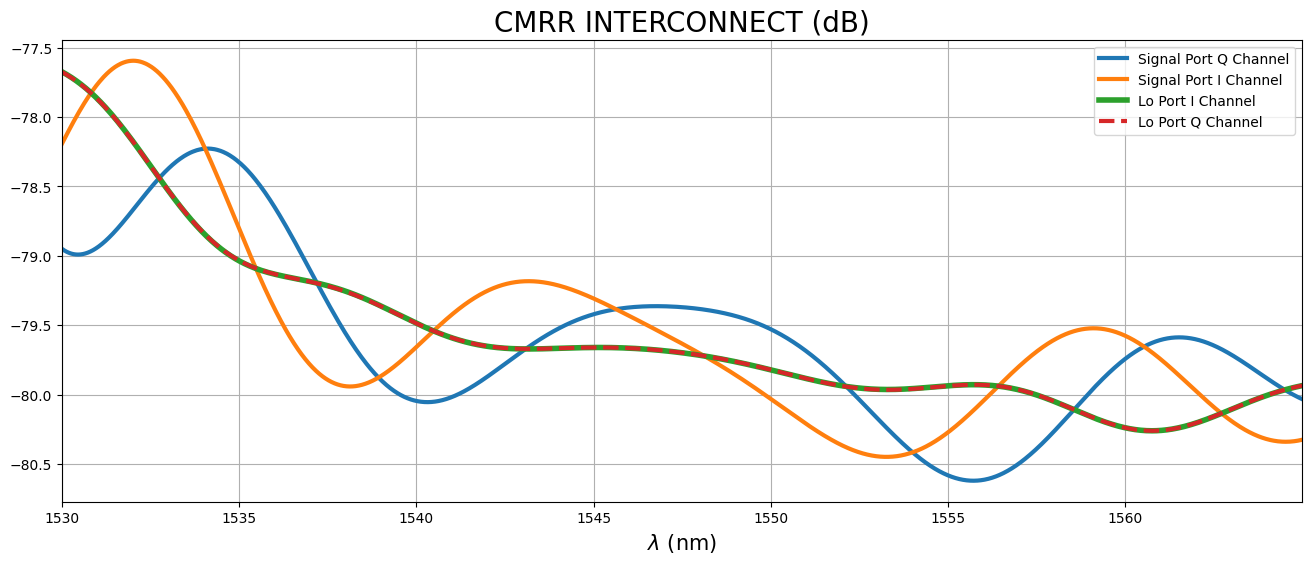

In [44]:
figure10 = plt.figure(figsize = (16,6))

# In this cell, i use CMRR function created on the first cell for convinience 

CMRR_S_Q = CMRR(Sig2, Sig3)
CMRR_S_I = CMRR(Sig4, Sig5)

CMRR_Lo_Q = CMRR(Lo2, Lo3)
CMRR_Lo_I = CMRR(Lo4, Lo5)

plt.plot(wavelength, CMRR_S_Q, linewidth = 3, label = 'Signal Port Q Channel')
plt.plot(wavelength, CMRR_S_I, linewidth = 3, label = 'Signal Port I Channel')
plt.plot(wavelength, CMRR_Lo_I, linewidth = 4, label = 'Lo Port I Channel')
plt.plot(wavelength, CMRR_Lo_Q,'--', linewidth = 3, label = 'Lo Port Q Channel')


plt.xticks(np.arange(1530,1565,5))
plt.xlim(1530,1565)
plt.legend()
plt.grid()
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.title('CMRR INTERCONNECT (dB)', size = 20)

plt.savefig('../Documentation/Figures/CMRR_Hybrid_INTERCONNECT')